In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import json
import math

import os
import zipfile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
zip_file_path = '/content/drive/MyDrive/public-test-images.zip'

# Specify the directory where you want to extract the contents
extract_to_dir = '/content/CustomDataset_Test'

# Open the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents of the ZIP file
    zip_ref.extractall(extract_to_dir)
    print("Files extracted successfully to", extract_to_dir)


Files extracted successfully to /content/CustomDataset_Test


In [ ]:
IMAGE_TRAIN_DIR = '/content/CustomDataset_Train/train-images'
JSON_TRAIN_PATH = '/content/drive/MyDrive/vimmsd-train.json'
IMAGE_TEST_DIR = '/content/CustomDataset_Test/dev-images'
JSON_TEST_PATH = '/content/drive/MyDrive/vimmsd-public-test.json'

In [ ]:
def access_json_path(JSON_PATH):
  with open(JSON_PATH, 'r') as file:
      data = json.load(file)
      return data

In [ ]:
class CustomMultiModalDataset(Dataset):
  """
    Init:

      Load DATA_DIR
      JSON_PATH
      -> Get list string keys

    Getitem:

      Image
      Caption
      Label

    Return:
      Transform_image(4 dimensions), Caption, Label
  """
  def __init__(self, data_folder, json_path, max_length=512, image_transform=None, text_transform=None):
        self.data_folder = data_folder
        self.json_path = json_path
        self.max_length = max_length
        self.keys = list(json_path.keys())

        # self.text_transform = text_transform

        # Define any image transformations if needed
        # Transformation -> Step 2
        self.image_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # AutoImageProcessor expects the mean
                                                                   # and standard deviation values to match the number of channels in the input images.
        ])

  def __len__(self):
        return len(self.keys)

  def __getitem__(self, idx):
        # Get index
        keys = self.keys[idx]
        image_idx = self.json_path[keys]['image']

        # Read image from hard drive
        image_path = os.path.join(self.data_folder, image_idx)
        image = Image.open(image_path).convert('RGB')
        # Transform image
        transformed_image = self.image_transform(image).unsqueeze(0)

        # Caption & Label
        caption = self.json_path[keys]['caption']
        label_str = self.json_path[keys]['label']

        if label_str == 'multi-sarcasm':
            label = torch.tensor([0, 1, 0, 0], dtype=torch.float32)
        elif label_str == 'image-sarcasm':
            label = torch.tensor([0, 0, 1, 0], dtype=torch.float32)
        elif label_str == 'text-sarcasm':
            label = torch.tensor([0, 0, 0, 1], dtype=torch.float32)
        else:
            label = torch.tensor([1, 0, 0, 0], dtype=torch.float32)

        return {
            'image_transformed': transformed_image,
            'caption': caption,
            'label': label
        }


In [ ]:
train_dataset = CustomMultiModalDataset(data_folder=IMAGE_TRAIN_DIR, json_path=access_json_path(JSON_TRAIN_PATH))

In [ ]:
train_loader = DataLoader(train_dataset,
                          batch_size=16,
                          shuffle=True,
                          num_workers=0) # Setting num_workers to 0 will make the DataLoader run in the main process, which avoids issues related to forking and threading.

In [ ]:
test_dataset = CustomMultiModalDataset(data_folder=IMAGE_TEST_DIR, json_path=access_json_path(JSON_TEST_PATH))

In [ ]:
test_loader = DataLoader(test_dataset,
                          batch_size=16,
                          shuffle=True,
                          num_workers=0) # Setting num_workers to 0 will make the DataLoader run in the main process, which avoids issues related to forking and threading.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def trainloader(train_loader):
    for i, batch in enumerate(train_loader):
        print(f"Batch {i}:")
        print(f"image: {batch['image_transformed']}")
        print(f"caption: {batch['caption']}")
        print(f"label: {batch['label']}")

trainloader(train_loader)

Batch 0:
image: tensor([[[[[ 0.6706,  0.6784,  0.6784,  ...,  0.6784,  0.6784,  0.6784],
           [ 0.6784,  0.6784,  0.6784,  ...,  0.6784,  0.6784,  0.6784],
           [ 0.6941,  0.6941,  0.6941,  ...,  0.6941,  0.6941,  0.6941],
           ...,
           [-0.5294, -0.5294, -0.5294,  ..., -0.5294, -0.5294, -0.5294],
           [-0.5294, -0.5294, -0.5294,  ..., -0.5294, -0.5294, -0.5294],
           [-0.5294, -0.5294, -0.5294,  ..., -0.5294, -0.5294, -0.5294]],

          [[ 0.6706,  0.6784,  0.6784,  ...,  0.6784,  0.6784,  0.6784],
           [ 0.6784,  0.6784,  0.6784,  ...,  0.6784,  0.6784,  0.6784],
           [ 0.6941,  0.6941,  0.6941,  ...,  0.6941,  0.6941,  0.6941],
           ...,
           [-0.5294, -0.5294, -0.5294,  ..., -0.5294, -0.5294, -0.5294],
           [-0.5294, -0.5294, -0.5294,  ..., -0.5294, -0.5294, -0.5294],
           [-0.5294, -0.5294, -0.5294,  ..., -0.5294, -0.5294, -0.5294]],

          [[ 0.6706,  0.6784,  0.6784,  ...,  0.6784,  0.6784,  0.6784],

In [ ]:
batch = next(iter(train_loader))
print(batch['image_transformed'][0], batch['caption'][0], batch['label'][0])

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]]) Nhật thực, nguyệt thực từ lâu đã là những hiện tượng thiên văn thu hút sự chú ý của 

In [ ]:
print(batch['image_transformed'].shape)
print(batch['label'].shape)

torch.Size([16, 3, 224, 224])
torch.Size([16, 4])


/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 128165 (\N{COLLISION SYMBOL}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 127873 (\N{WRAPPED PRESENT}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 128073 (\N{WHITE RIGHT POINTING BACKHAND INDEX}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from current font.
  func(*args, **kwargs)


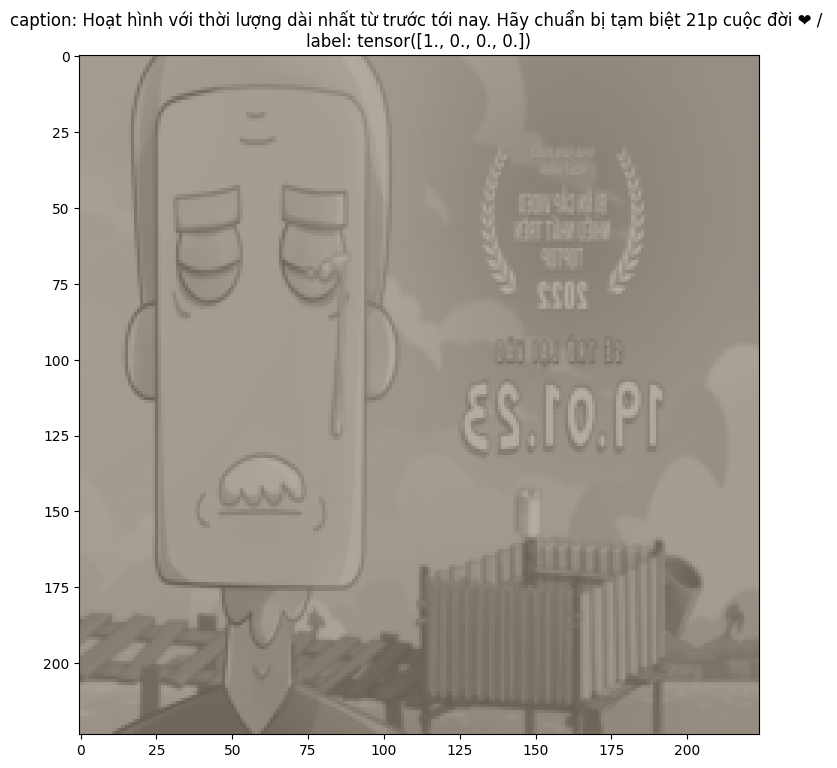

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128165 (\N{COLLISION SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127873 (\N{WRAPPED PRESENT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128073 (\N{WHITE RIGHT POINTING BACKHAND INDEX}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


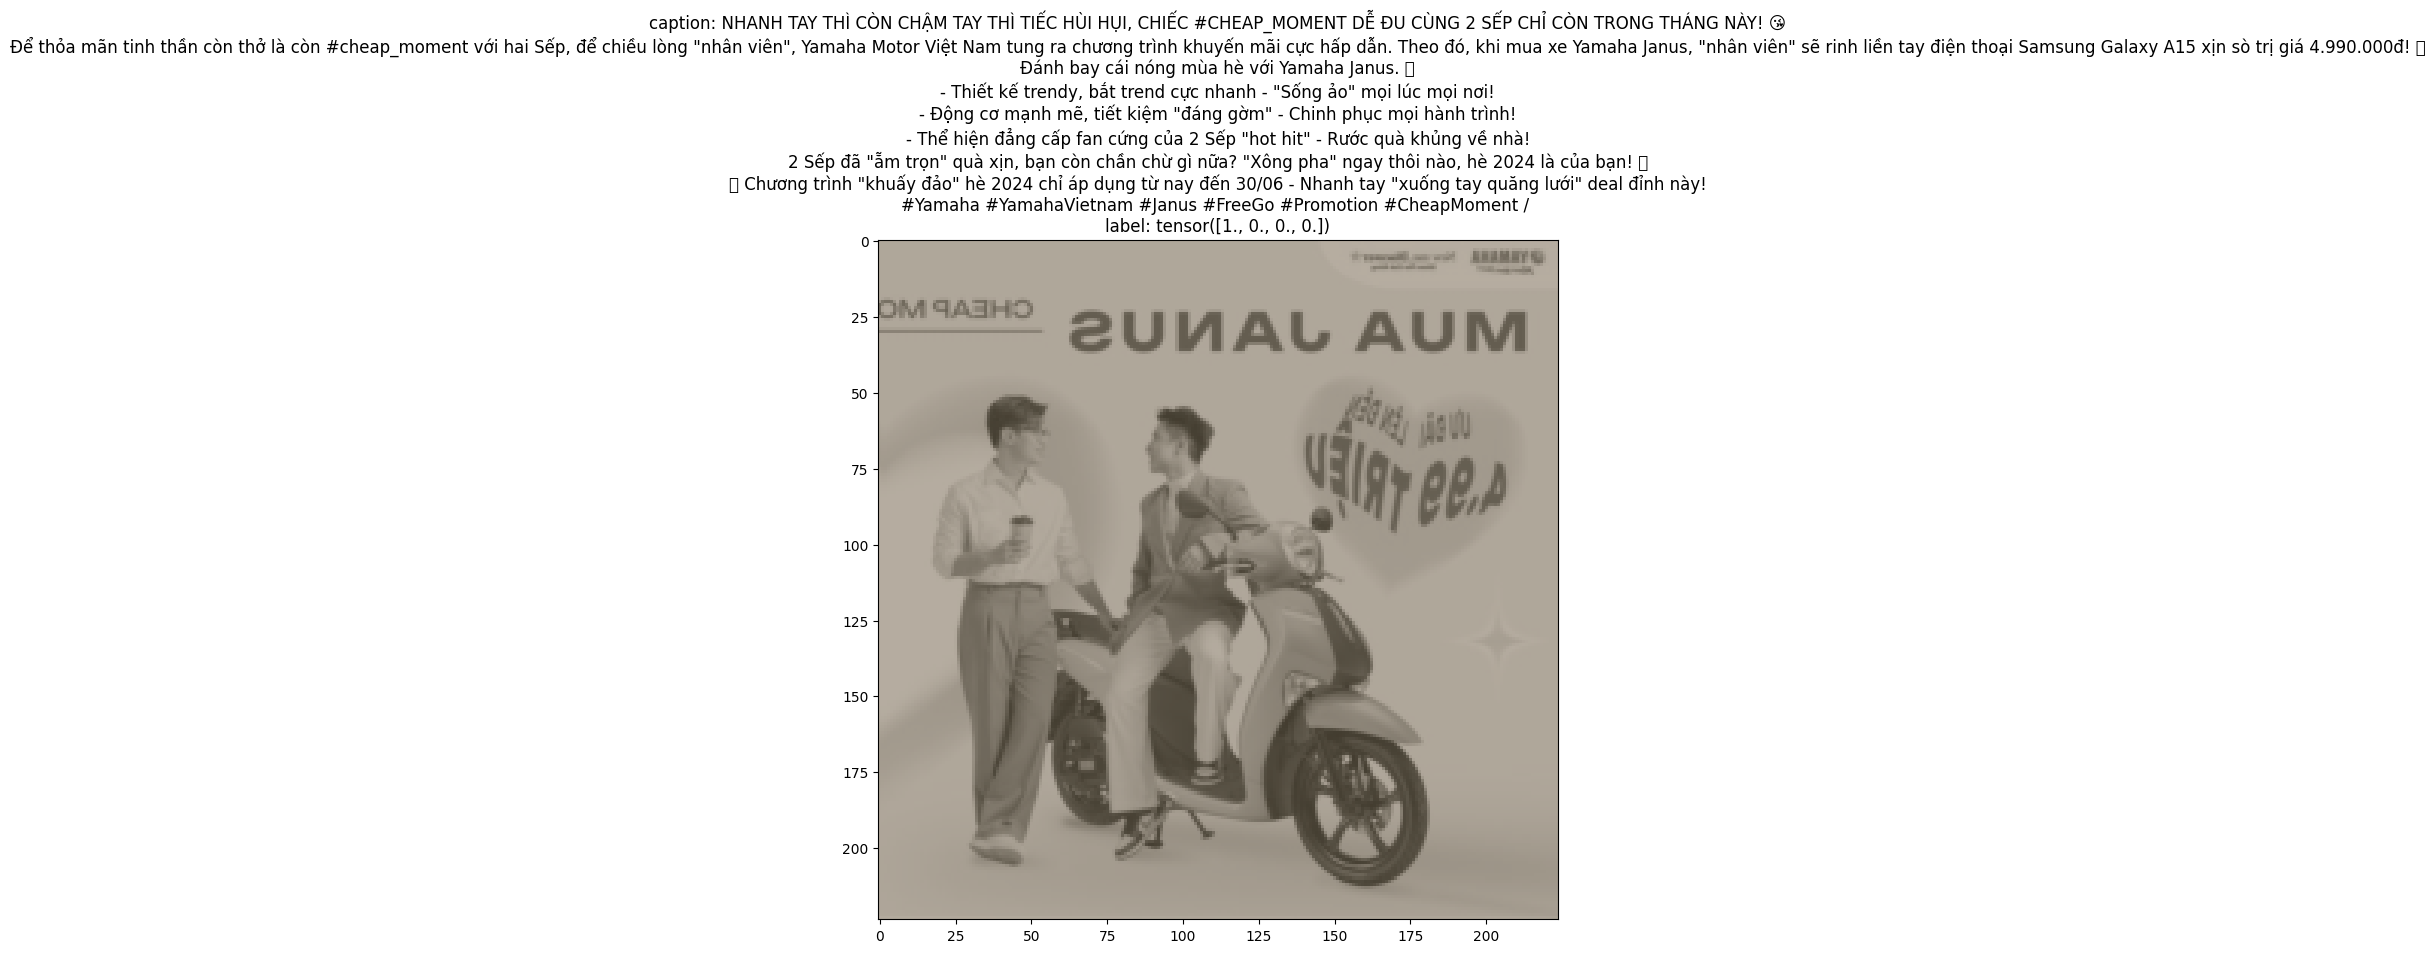

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


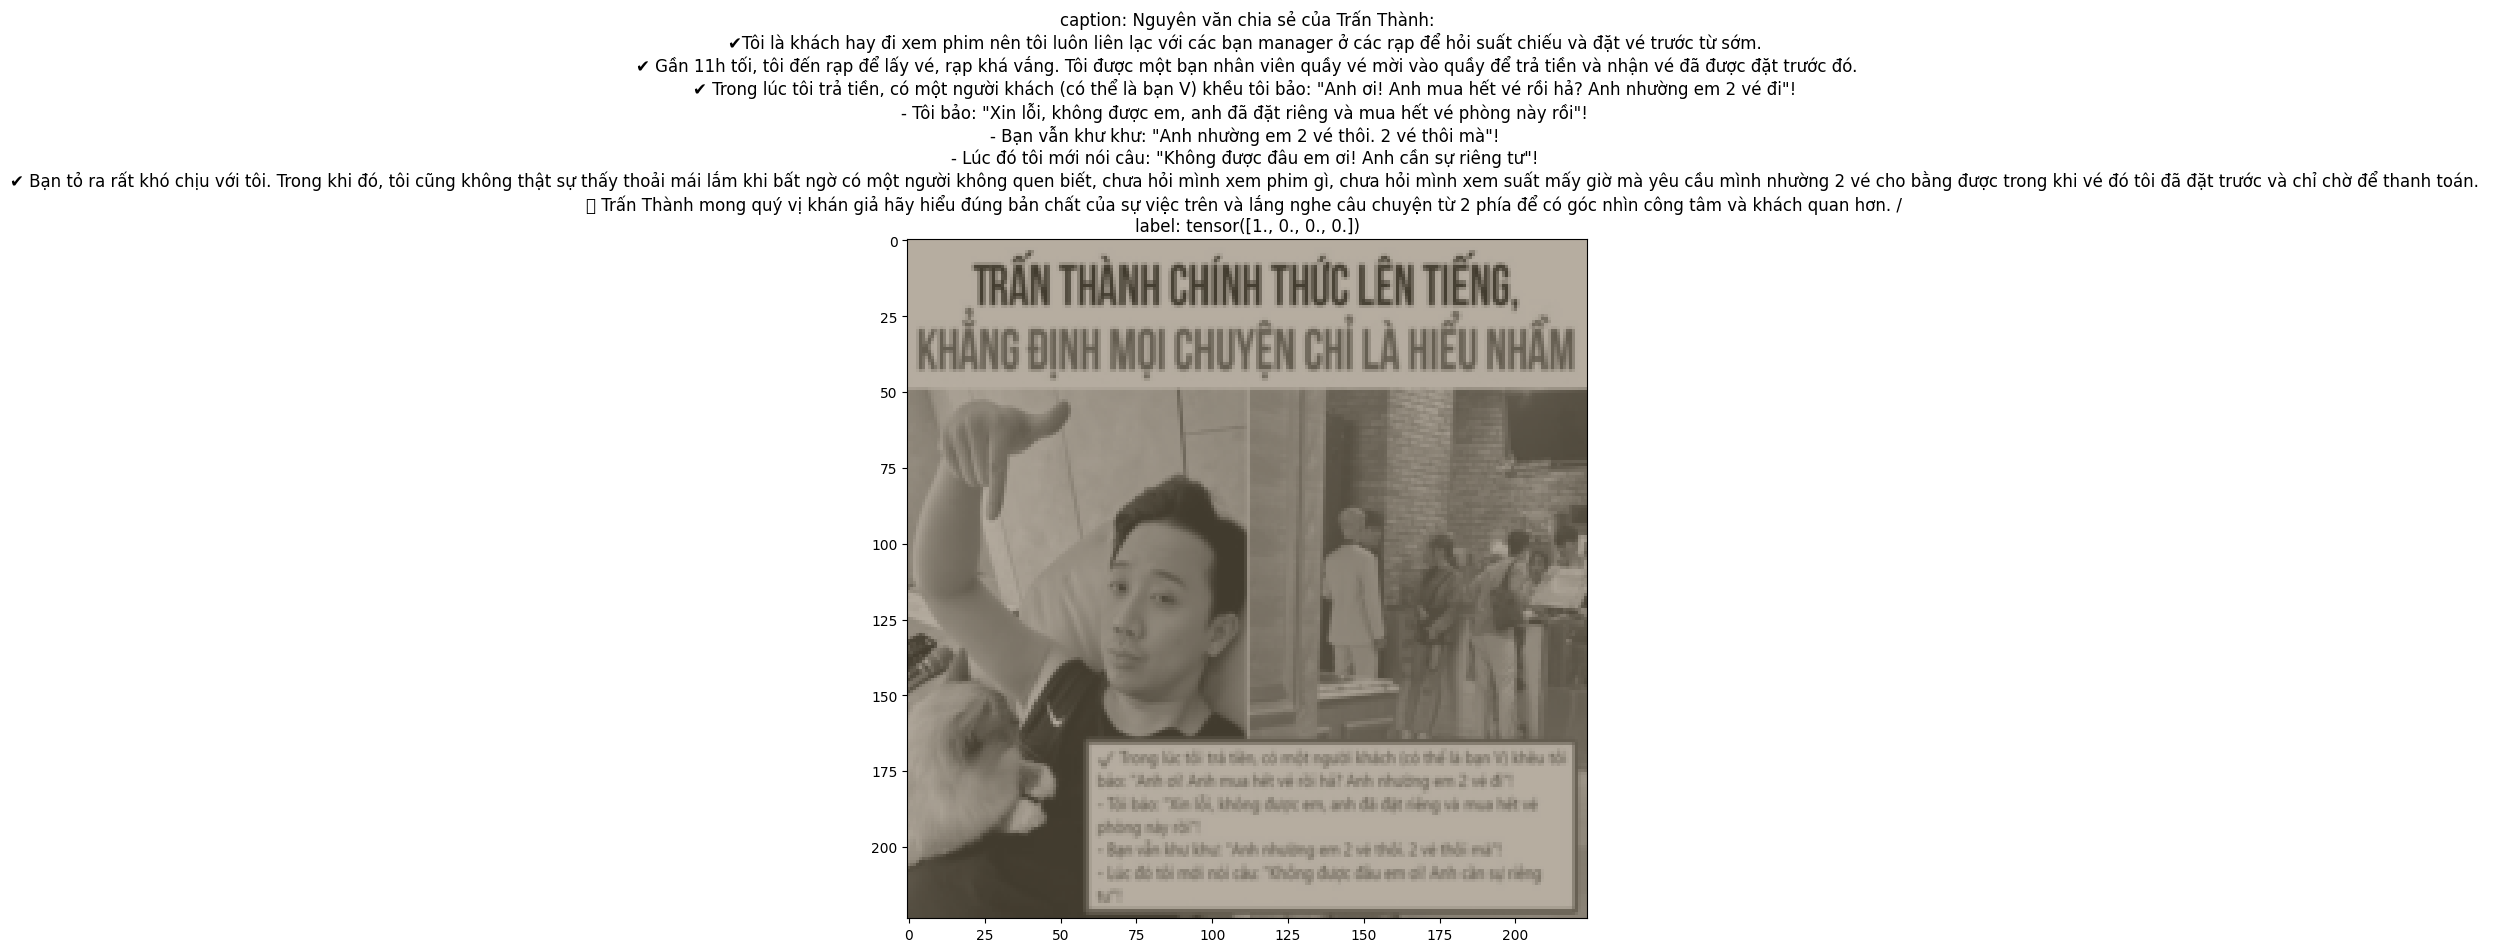

In [ ]:
def plot(train_loader, batch):
  """
    Plot image + caption + label

    Notion:
      Get image with 3 dimension [height, width, channel]
  """
  for i in range(len(batch)):
      image = batch['image_transformed'][i] # -> 3 dimension [channel, height, width]
      caption = batch['caption'][i]
      label = batch['label'][i]
      # Reshape to [height, width, channels]
      image_reshaped = image.permute(1, 2, 0).numpy() # [height, width, channel]
      # Unnormalize the image
      mean = [0.485, 0.456, 0.406]
      std = [0.229, 0.224, 0.225]
      image = std * image_reshaped + mean
      image = np.clip(image, 0, 1)
      plt.figure(figsize=(50,30))
      plt.subplot(3,1, i+1)
      plt.imshow(image)
      plt.title(f'caption: {caption} / \nlabel: {label}')




plot(train_loader, batch)

In [ ]:
from transformers import AutoModel, AutoTokenizer, VisualBertModel

In [ ]:
from tqdm import tqdm

In [ ]:
model = VisualBertModel.from_pretrained("uclanlp/visualbert-vqa-coco-pre")
phobert = AutoModel.from_pretrained("vinai/phobert-base")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/448M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
phobert

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(64001, 768, padding_idx=1)
    (position_embeddings): Embedding(258, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

In [ ]:
model

VisualBertModel(
  (embeddings): VisualBertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=1)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (visual_token_type_embeddings): Embedding(2, 768)
    (visual_position_embeddings): Embedding(512, 768)
    (visual_projection): Linear(in_features=2048, out_features=768, bias=True)
  )
  (encoder): VisualBertEncoder(
    (layer): ModuleList(
      (0-11): 12 x VisualBertLayer(
        (attention): VisualBertAttention(
          (self): VisualBertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): V

In [ ]:
from transformers import VisualBertModel, AutoModel


class VisualBertForClassification(nn.Module):
    def __init__(self, num_labels):
        super(VisualBertForClassification, self).__init__()
        self.visualbert = VisualBertModel.from_pretrained("uclanlp/visualbert-vqa-coco-pre")
        self.phobert = AutoModel.from_pretrained("vinai/phobert-base")

        # Replace the embedding layers to match PhoBERT
        self.visualbert.embeddings.word_embeddings = self.phobert.embeddings.word_embeddings
        self.visualbert.position_embeddings = self.phobert.embeddings.position_embeddings
        self.visualbert.token_type_embeddings = self.phobert.embeddings.token_type_embeddings

        # Use the correct size for the classifier
        self.classifier = nn.Linear(self.visualbert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids, visual_embeds, visual_token_type_ids, visual_attention_mask):

        # Get outputs from VisualBERT
        outputs = self.visualbert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            visual_embeds=visual_embeds,
            visual_token_type_ids=visual_token_type_ids,
            visual_attention_mask=visual_attention_mask
        )

        # Use the pooled output for classification
        pooled_output = outputs.pooler_output  # Shape: (batch_size, 768)
        print("Pooled output shape:", pooled_output.shape)

        # Compute logits from the pooled output
        logits = self.classifier(pooled_output)

        return logits


In [ ]:
num_labels = 4  # Adjust based on your classification task
model = VisualBertForClassification(num_labels).to(device)

In [ ]:
model

VisualBertForClassification(
  (visualbert): VisualBertModel(
    (embeddings): VisualBertEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (visual_token_type_embeddings): Embedding(2, 768)
      (visual_position_embeddings): Embedding(512, 768)
      (visual_projection): Linear(in_features=2048, out_features=768, bias=True)
    )
    (encoder): VisualBertEncoder(
      (layer): ModuleList(
        (0-11): 12 x VisualBertLayer(
          (attention): VisualBertAttention(
            (self): VisualBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
     

In [ ]:
from transformers import AutoImageProcessor, ViTModel

In [ ]:
def visual_embeddings(image):
    feature_extractor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
    model = ViTModel.from_pretrained("google/vit-base-patch16-224").to(device)
    model.eval()

    # Load and preprocess the image using the feature extractor for ViT
    inputs = feature_extractor(images=image, return_tensors="pt").to(device)
    # inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get the embeddings
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state

    # Process the embeddings to match the shape (batch_size, 1, 2048)
    embeddings = embeddings.mean(dim=1)  # Average over the sequence length
    embeddings = embeddings.unsqueeze(1)  # Add sequence dimension
    embeddings = torch.nn.functional.adaptive_avg_pool2d(embeddings, (1, 2048))  # Ensure the last dimension is 2048

    return embeddings



In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.00001)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 2
total_loss = 0
torch.cuda.empty_cache()
for epoch in range(num_epochs):
  model.train()
  for batch in tqdm(train_loader):
      images = batch['image_transformed'].to(device)  # Shape: (batch_size, 3, 224, 224)
      caption = batch['caption']
      label = batch['label'].to(device)
      images = images.squeeze(1).to(device)

      optimizer.zero_grad()

      images = (images + 1) / 2  # Assuming images are in range [-1, 1]
      images = torch.clamp(images, 0, 1)  # Ensure values are in [0, 1]


      # Tokenize captions
      inputs = tokenizer(caption, return_tensors="pt", padding='max_length', truncation=True, max_length=512).to(device)
      visual_embeds = visual_embeddings(images).to(device)
      print("Visual embeds shape after extraction:", visual_embeds.shape)


      # Create visual token type and attention masks
      visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long).to(device)
      visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.float).to(device)

      #print("Input IDs shape:", inputs['input_ids'].shape) # (batch, dimension)
      #print("Attention mask shape:", inputs['attention_mask'].shape) # (batch, dimension)
      #print("Token type IDs shape:", inputs['token_type_ids'].shape) # (batch, dimension)
      #print("Visual embeds shape:", visual_embeds.shape)             #(batch, num patch, dimension)
      #print("Visual token type IDs shape:", visual_token_type_ids.shape) # (batch, num patch)
      #print("Visual attention mask shape:", visual_attention_mask.shape) # (batch, num patch)

      # Forward pass
      inputs.update ({
          "visual_embeds": visual_embeds,
          "visual_token_type_ids": visual_token_type_ids,
          "visual_attention_mask": visual_attention_mask,
      }
    )
      outputs = model(**inputs)
      # Calculate loss
      loss_value = loss_fn(outputs, label)

      # Backward pass and optimization
      loss_value.backward()
      optimizer.step()

      total_loss += loss_value.item()
      print(f"Batch Loss: {loss_value.item()}")  # Print loss for the current batch

    # Print average loss for the epoch
  avg_epoch_loss = total_loss / len(train_loader)
  print(f"total test loss: {total_loss}")
  print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_epoch_loss:.4f}")

  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': total_loss
            }, "visual_bert_epoch_{epoch}.pth")

  print(f"Model weights saved for epoch {epoch}.")

  # Evaluation
  model.eval()  # Set the model to evaluation mode
  total_test_loss = 0
  with torch.no_grad():  # Disable gradient calculation
      for batch in tqdm(test_loader):
          images = batch['image_transformed'].to(device)
          caption = batch['caption']
          label = batch['label'].to(device)
          images = images.squeeze(1).to(device)

          images = (images + 1) / 2  # Normalize images
          images = torch.clamp(images, 0, 1)

          # Tokenize captions
          inputs = tokenizer(caption, return_tensors="pt", padding='max_length', truncation=True, max_length=512).to(device)
          visual_embeds = visual_embeddings(images).to(device)

          # Create visual token type and attention masks
          visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long).to(device)
          visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.float).to(device)

          # Prepare inputs for the model
          inputs.update({
              "visual_embeds": visual_embeds,
              "visual_token_type_ids": visual_token_type_ids,
              "visual_attention_mask": visual_attention_mask,
          })

          # Forward pass
          outputs = model(**inputs)
          # Calculate loss
          loss_value = loss_fn(outputs, label)

          total_test_loss += loss_value.item()

          print(f"Test Batch Loss: {loss_value.item()}")  # Print loss for the current test batch

  # Print average test loss
  avg_test_loss = total_test_loss / len(test_loader)
  print(f"total test loss: {total_test_loss}")
  print(f"Average Test Loss: {avg_test_loss:.4f}")

  0%|          | 0/676 [00:00<?, ?it/s]Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  0%|          | 1/676 [00:04<49:07,  4.37s/it]

Batch Loss: 0.6590728759765625


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  0%|          | 2/676 [00:07<43:51,  3.90s/it]

Batch Loss: 0.4917442798614502


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  0%|          | 3/676 [00:11<43:28,  3.88s/it]

Batch Loss: 0.48420092463493347


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  1%|          | 4/676 [00:16<44:56,  4.01s/it]

Batch Loss: 0.6610894203186035


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  1%|          | 5/676 [00:19<42:34,  3.81s/it]

Batch Loss: 0.8077300190925598


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  1%|          | 6/676 [00:23<42:07,  3.77s/it]

Batch Loss: 0.6613569259643555


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  1%|          | 7/676 [00:26<40:30,  3.63s/it]

Batch Loss: 0.7320696711540222


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  1%|          | 8/676 [00:29<38:53,  3.49s/it]

Batch Loss: 1.262946367263794


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  1%|▏         | 9/676 [00:32<37:43,  3.39s/it]

Batch Loss: 0.4639561176300049


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  1%|▏         | 10/676 [00:36<36:50,  3.32s/it]

Batch Loss: 1.353525996208191


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  2%|▏         | 11/676 [00:39<36:07,  3.26s/it]

Batch Loss: 0.859021782875061


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  2%|▏         | 12/676 [00:42<35:48,  3.23s/it]

Batch Loss: 0.6685160994529724


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  2%|▏         | 13/676 [00:45<35:23,  3.20s/it]

Batch Loss: 0.9108179211616516


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  2%|▏         | 14/676 [00:48<34:58,  3.17s/it]

Batch Loss: 0.7545038461685181


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  2%|▏         | 15/676 [00:51<35:03,  3.18s/it]

Batch Loss: 0.9520711898803711


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  2%|▏         | 16/676 [00:54<35:10,  3.20s/it]

Batch Loss: 0.888340950012207


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  3%|▎         | 17/676 [00:58<34:47,  3.17s/it]

Batch Loss: 0.6230150461196899


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  3%|▎         | 18/676 [01:01<35:12,  3.21s/it]

Batch Loss: 0.5680500268936157


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  3%|▎         | 19/676 [01:04<35:01,  3.20s/it]

Batch Loss: 0.6245974898338318


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  3%|▎         | 20/676 [01:07<35:05,  3.21s/it]

Batch Loss: 0.5788359045982361


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  3%|▎         | 21/676 [01:11<35:14,  3.23s/it]

Batch Loss: 0.6116063594818115


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  3%|▎         | 22/676 [01:14<34:41,  3.18s/it]

Batch Loss: 0.650629997253418


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  3%|▎         | 23/676 [01:17<34:34,  3.18s/it]

Batch Loss: 0.45300063490867615


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  4%|▎         | 24/676 [01:20<34:40,  3.19s/it]

Batch Loss: 0.5425696969032288


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  4%|▎         | 25/676 [01:23<34:22,  3.17s/it]

Batch Loss: 0.5036941766738892


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  4%|▍         | 26/676 [01:26<34:13,  3.16s/it]

Batch Loss: 0.5984042882919312


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  4%|▍         | 27/676 [01:31<39:18,  3.63s/it]

Batch Loss: 0.7141518592834473


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  4%|▍         | 28/676 [01:34<38:18,  3.55s/it]

Batch Loss: 0.6866910457611084


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  4%|▍         | 29/676 [01:37<36:44,  3.41s/it]

Batch Loss: 0.5475345849990845


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  4%|▍         | 30/676 [01:41<35:52,  3.33s/it]

Batch Loss: 0.7018354535102844


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  5%|▍         | 31/676 [01:44<35:22,  3.29s/it]

Batch Loss: 0.6262814998626709


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  5%|▍         | 32/676 [01:47<34:55,  3.25s/it]

Batch Loss: 0.9409071803092957


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  5%|▍         | 33/676 [01:50<34:28,  3.22s/it]

Batch Loss: 0.675823450088501


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  5%|▌         | 34/676 [01:53<34:44,  3.25s/it]

Batch Loss: 0.9710526466369629


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  5%|▌         | 35/676 [01:57<36:01,  3.37s/it]

Batch Loss: 1.1147669553756714


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  5%|▌         | 36/676 [02:00<35:17,  3.31s/it]

Batch Loss: 0.6624173521995544


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  5%|▌         | 37/676 [02:03<34:40,  3.26s/it]

Batch Loss: 0.7654821276664734


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  6%|▌         | 38/676 [02:06<34:08,  3.21s/it]

Batch Loss: 0.6775399446487427


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  6%|▌         | 39/676 [02:10<34:06,  3.21s/it]

Batch Loss: 0.6844774484634399


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  6%|▌         | 40/676 [02:13<34:32,  3.26s/it]

Batch Loss: 0.6136763095855713


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  6%|▌         | 41/676 [02:17<35:55,  3.39s/it]

Batch Loss: 0.7674607038497925


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  6%|▌         | 42/676 [02:20<36:38,  3.47s/it]

Batch Loss: 0.7134370803833008


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  6%|▋         | 43/676 [02:24<35:46,  3.39s/it]

Batch Loss: 0.5483995676040649


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  7%|▋         | 44/676 [02:27<35:15,  3.35s/it]

Batch Loss: 0.7849379777908325


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  7%|▋         | 45/676 [02:30<34:28,  3.28s/it]

Batch Loss: 0.9420425891876221


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  7%|▋         | 46/676 [02:33<33:52,  3.23s/it]

Batch Loss: 0.537962794303894


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  7%|▋         | 47/676 [02:36<33:40,  3.21s/it]

Batch Loss: 0.5341112017631531


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  7%|▋         | 48/676 [02:40<34:19,  3.28s/it]

Batch Loss: 0.8123977184295654


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  7%|▋         | 49/676 [02:43<33:50,  3.24s/it]

Batch Loss: 0.576377272605896


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  7%|▋         | 50/676 [02:46<33:23,  3.20s/it]

Batch Loss: 0.4977213740348816


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  8%|▊         | 51/676 [02:49<33:22,  3.20s/it]

Batch Loss: 0.5923901796340942


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  8%|▊         | 52/676 [02:53<34:49,  3.35s/it]

Batch Loss: 0.6412863731384277


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  8%|▊         | 53/676 [02:56<33:59,  3.27s/it]

Batch Loss: 0.5009365677833557


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  8%|▊         | 54/676 [02:59<33:27,  3.23s/it]

Batch Loss: 0.4732334315776825


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  8%|▊         | 55/676 [03:02<33:17,  3.22s/it]

Batch Loss: 0.5154371857643127


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  8%|▊         | 56/676 [03:06<33:28,  3.24s/it]

Batch Loss: 0.8227115273475647


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  8%|▊         | 57/676 [03:09<32:59,  3.20s/it]

Batch Loss: 1.1538796424865723


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  9%|▊         | 58/676 [03:12<32:40,  3.17s/it]

Batch Loss: 0.4136389493942261


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  9%|▊         | 59/676 [03:15<32:42,  3.18s/it]

Batch Loss: 0.7976950407028198


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  9%|▉         | 60/676 [03:18<32:46,  3.19s/it]

Batch Loss: 0.5559716820716858


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  9%|▉         | 61/676 [03:21<32:22,  3.16s/it]

Batch Loss: 0.46104997396469116


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  9%|▉         | 62/676 [03:24<32:05,  3.14s/it]

Batch Loss: 0.527119517326355


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  9%|▉         | 63/676 [03:27<32:00,  3.13s/it]

Batch Loss: 0.9002867937088013


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  9%|▉         | 64/676 [03:31<32:26,  3.18s/it]

Batch Loss: 0.9216875433921814


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 10%|▉         | 65/676 [03:34<33:44,  3.31s/it]

Batch Loss: 0.6916497349739075


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 10%|▉         | 66/676 [03:38<33:10,  3.26s/it]

Batch Loss: 0.5813779830932617


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 10%|▉         | 67/676 [03:41<33:11,  3.27s/it]

Batch Loss: 1.0507724285125732


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 10%|█         | 68/676 [03:44<33:28,  3.30s/it]

Batch Loss: 0.9396696090698242


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 10%|█         | 69/676 [03:47<32:46,  3.24s/it]

Batch Loss: 0.8343261480331421


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 10%|█         | 70/676 [03:52<35:38,  3.53s/it]

Batch Loss: 0.7331469655036926


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 11%|█         | 71/676 [03:55<34:48,  3.45s/it]

Batch Loss: 0.7208120822906494


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 11%|█         | 72/676 [03:58<34:05,  3.39s/it]

Batch Loss: 0.8356800675392151


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 11%|█         | 73/676 [04:01<33:15,  3.31s/it]

Batch Loss: 0.7851177453994751


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 11%|█         | 74/676 [04:04<32:45,  3.26s/it]

Batch Loss: 0.7269080877304077


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 11%|█         | 75/676 [04:08<32:43,  3.27s/it]

Batch Loss: 0.5304281115531921


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 11%|█         | 76/676 [04:11<32:27,  3.25s/it]

Batch Loss: 0.6710720062255859


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 11%|█▏        | 77/676 [04:14<32:05,  3.21s/it]

Batch Loss: 0.5554304122924805


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 12%|█▏        | 78/676 [04:17<32:39,  3.28s/it]

Batch Loss: 0.5538932085037231


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 12%|█▏        | 79/676 [04:21<32:31,  3.27s/it]

Batch Loss: 0.45315560698509216


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 12%|█▏        | 80/676 [04:24<32:37,  3.28s/it]

Batch Loss: 0.7582571506500244


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 12%|█▏        | 81/676 [04:27<32:38,  3.29s/it]

Batch Loss: 0.6163473129272461


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 12%|█▏        | 82/676 [04:31<33:21,  3.37s/it]

Batch Loss: 0.6715431213378906


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 12%|█▏        | 83/676 [04:34<33:26,  3.38s/it]

Batch Loss: 0.45723703503608704


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 12%|█▏        | 84/676 [04:38<33:38,  3.41s/it]

Batch Loss: 1.0645356178283691


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 13%|█▎        | 85/676 [04:41<33:24,  3.39s/it]

Batch Loss: 0.9654979705810547


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 13%|█▎        | 86/676 [04:44<32:38,  3.32s/it]

Batch Loss: 0.903494656085968


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 13%|█▎        | 87/676 [04:47<32:22,  3.30s/it]

Batch Loss: 0.7808824181556702


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 13%|█▎        | 88/676 [04:51<33:25,  3.41s/it]

Batch Loss: 0.8659390211105347


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 13%|█▎        | 89/676 [04:54<32:36,  3.33s/it]

Batch Loss: 0.39912036061286926


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 13%|█▎        | 90/676 [04:57<32:09,  3.29s/it]

Batch Loss: 0.745954155921936


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 13%|█▎        | 91/676 [05:01<32:12,  3.30s/it]

Batch Loss: 0.6639598608016968


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 14%|█▎        | 92/676 [05:04<32:38,  3.35s/it]

Batch Loss: 0.7231086492538452


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 14%|█▍        | 93/676 [05:07<32:02,  3.30s/it]

Batch Loss: 0.5124417543411255


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 14%|█▍        | 94/676 [05:11<32:57,  3.40s/it]

Batch Loss: 0.7370483875274658


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 14%|█▍        | 95/676 [05:14<32:32,  3.36s/it]

Batch Loss: 0.7625930905342102


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 14%|█▍        | 96/676 [05:18<32:03,  3.32s/it]

Batch Loss: 0.4492650628089905


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 14%|█▍        | 97/676 [05:21<32:20,  3.35s/it]

Batch Loss: 0.5204963088035583


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 14%|█▍        | 98/676 [05:24<31:48,  3.30s/it]

Batch Loss: 0.6671428680419922


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 15%|█▍        | 99/676 [05:28<32:03,  3.33s/it]

Batch Loss: 0.7280892133712769


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 15%|█▍        | 100/676 [05:31<31:47,  3.31s/it]

Batch Loss: 0.7198588848114014


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 15%|█▍        | 101/676 [05:34<31:30,  3.29s/it]

Batch Loss: 0.25133758783340454


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 15%|█▌        | 102/676 [05:37<31:12,  3.26s/it]

Batch Loss: 0.666199803352356


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 15%|█▌        | 103/676 [05:41<31:11,  3.27s/it]

Batch Loss: 0.5338195562362671


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 15%|█▌        | 104/676 [05:44<31:15,  3.28s/it]

Batch Loss: 0.8388785123825073


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 16%|█▌        | 105/676 [05:47<30:44,  3.23s/it]

Batch Loss: 0.6792884469032288


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 16%|█▌        | 106/676 [05:50<30:32,  3.22s/it]

Batch Loss: 0.4143936038017273


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 16%|█▌        | 107/676 [05:53<30:45,  3.24s/it]

Batch Loss: 0.7975520491600037


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 16%|█▌        | 108/676 [05:57<30:38,  3.24s/it]

Batch Loss: 0.6945696473121643


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 16%|█▌        | 109/676 [06:00<30:15,  3.20s/it]

Batch Loss: 1.0550129413604736


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 16%|█▋        | 110/676 [06:03<31:33,  3.35s/it]

Batch Loss: 0.9927585124969482


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 16%|█▋        | 111/676 [06:07<31:14,  3.32s/it]

Batch Loss: 0.6428179740905762


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 17%|█▋        | 112/676 [06:10<30:54,  3.29s/it]

Batch Loss: 0.5822471380233765


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 17%|█▋        | 113/676 [06:13<30:59,  3.30s/it]

Batch Loss: 0.6664870977401733


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 17%|█▋        | 114/676 [06:16<30:23,  3.24s/it]

Batch Loss: 0.5818893909454346


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 17%|█▋        | 115/676 [06:20<30:15,  3.24s/it]

Batch Loss: 0.733759880065918


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 17%|█▋        | 116/676 [06:23<30:14,  3.24s/it]

Batch Loss: 0.7494578957557678


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 17%|█▋        | 117/676 [06:27<31:34,  3.39s/it]

Batch Loss: 0.5764373540878296


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 17%|█▋        | 118/676 [06:30<30:50,  3.32s/it]

Batch Loss: 0.6245120167732239


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 18%|█▊        | 119/676 [06:33<30:40,  3.31s/it]

Batch Loss: 0.7555781602859497


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 18%|█▊        | 120/676 [06:37<31:40,  3.42s/it]

Batch Loss: 0.6377685070037842


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 18%|█▊        | 121/676 [06:40<30:50,  3.33s/it]

Batch Loss: 0.8069754838943481


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 18%|█▊        | 122/676 [06:43<30:36,  3.31s/it]

Batch Loss: 0.7904325127601624


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 18%|█▊        | 123/676 [06:46<30:38,  3.32s/it]

Batch Loss: 0.8005802631378174


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 18%|█▊        | 124/676 [06:50<31:10,  3.39s/it]

Batch Loss: 0.6718950271606445


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 18%|█▊        | 125/676 [06:53<31:13,  3.40s/it]

Batch Loss: 0.6916384696960449


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 19%|█▊        | 126/676 [06:57<30:38,  3.34s/it]

Batch Loss: 0.9458744525909424


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 19%|█▉        | 127/676 [07:00<30:35,  3.34s/it]

Batch Loss: 0.6359907388687134


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 19%|█▉        | 128/676 [07:03<30:11,  3.31s/it]

Batch Loss: 0.8609414100646973


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 19%|█▉        | 129/676 [07:06<29:54,  3.28s/it]

Batch Loss: 0.8952003717422485


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 19%|█▉        | 130/676 [07:10<29:38,  3.26s/it]

Batch Loss: 0.5078310370445251


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 19%|█▉        | 131/676 [07:13<29:33,  3.25s/it]

Batch Loss: 0.7184535264968872


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 20%|█▉        | 132/676 [07:16<29:35,  3.26s/it]

Batch Loss: 0.4244503080844879


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 20%|█▉        | 133/676 [07:19<29:20,  3.24s/it]

Batch Loss: 0.6398607492446899


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 20%|█▉        | 134/676 [07:24<32:19,  3.58s/it]

Batch Loss: 0.5958414077758789


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 20%|█▉        | 135/676 [07:27<31:54,  3.54s/it]

Batch Loss: 0.8327031135559082


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 20%|██        | 136/676 [07:31<31:36,  3.51s/it]

Batch Loss: 0.7271957397460938


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 20%|██        | 137/676 [07:34<31:22,  3.49s/it]

Batch Loss: 0.6062268018722534


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 20%|██        | 138/676 [07:37<30:29,  3.40s/it]

Batch Loss: 1.370722770690918


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 21%|██        | 139/676 [07:41<30:35,  3.42s/it]

Batch Loss: 0.6615316867828369


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 21%|██        | 140/676 [07:44<29:38,  3.32s/it]

Batch Loss: 0.693362832069397


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 21%|██        | 141/676 [07:47<29:09,  3.27s/it]

Batch Loss: 0.477372407913208


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 21%|██        | 142/676 [07:50<28:45,  3.23s/it]

Batch Loss: 0.8457013964653015


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 21%|██        | 143/676 [07:54<30:06,  3.39s/it]

Batch Loss: 0.9387848377227783


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 21%|██▏       | 144/676 [07:57<30:41,  3.46s/it]

Batch Loss: 0.7356665134429932


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 21%|██▏       | 145/676 [08:01<30:01,  3.39s/it]

Batch Loss: 0.709125816822052


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 22%|██▏       | 146/676 [08:04<29:17,  3.32s/it]

Batch Loss: 0.592736005783081


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 22%|██▏       | 147/676 [08:07<29:36,  3.36s/it]

Batch Loss: 0.563202977180481


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 22%|██▏       | 148/676 [08:11<30:08,  3.43s/it]

Batch Loss: 0.54603111743927


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 22%|██▏       | 149/676 [08:14<29:21,  3.34s/it]

Batch Loss: 0.8537499904632568


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 22%|██▏       | 150/676 [08:18<31:01,  3.54s/it]

Batch Loss: 0.7639945149421692


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 22%|██▏       | 151/676 [08:21<30:38,  3.50s/it]

Batch Loss: 0.7546611428260803


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 22%|██▏       | 152/676 [08:25<29:33,  3.39s/it]

Batch Loss: 0.5166447162628174


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 23%|██▎       | 153/676 [08:28<28:49,  3.31s/it]

Batch Loss: 0.4734668433666229


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 23%|██▎       | 154/676 [08:31<28:18,  3.25s/it]

Batch Loss: 0.575054943561554


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 23%|██▎       | 155/676 [08:34<28:37,  3.30s/it]

Batch Loss: 0.6406505703926086


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 23%|██▎       | 156/676 [08:37<28:12,  3.25s/it]

Batch Loss: 0.715794563293457


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 23%|██▎       | 157/676 [08:40<27:54,  3.23s/it]

Batch Loss: 0.727219820022583


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 23%|██▎       | 158/676 [08:44<27:38,  3.20s/it]

Batch Loss: 0.5068747401237488


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 24%|██▎       | 159/676 [08:47<27:55,  3.24s/it]

Batch Loss: 0.4919329881668091


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 24%|██▎       | 160/676 [08:50<27:54,  3.24s/it]

Batch Loss: 0.5304991602897644


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 24%|██▍       | 161/676 [08:53<27:31,  3.21s/it]

Batch Loss: 1.0224586725234985


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 24%|██▍       | 162/676 [08:57<27:22,  3.20s/it]

Batch Loss: 0.6422364711761475


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 24%|██▍       | 163/676 [09:00<27:24,  3.21s/it]

Batch Loss: 1.080517292022705


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 24%|██▍       | 164/676 [09:03<27:26,  3.22s/it]

Batch Loss: 0.5723545551300049


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 24%|██▍       | 165/676 [09:06<27:08,  3.19s/it]

Batch Loss: 0.8230593204498291


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 25%|██▍       | 166/676 [09:09<26:56,  3.17s/it]

Batch Loss: 0.7183641195297241


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 25%|██▍       | 167/676 [09:12<27:08,  3.20s/it]

Batch Loss: 0.7895597219467163


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 25%|██▍       | 168/676 [09:16<27:27,  3.24s/it]

Batch Loss: 0.6335232257843018


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 25%|██▌       | 169/676 [09:19<27:10,  3.22s/it]

Batch Loss: 0.5486811399459839


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 25%|██▌       | 170/676 [09:22<26:54,  3.19s/it]

Batch Loss: 0.5964247584342957


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 25%|██▌       | 171/676 [09:25<26:55,  3.20s/it]

Batch Loss: 0.5935210585594177


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 25%|██▌       | 172/676 [09:29<27:03,  3.22s/it]

Batch Loss: 0.6436245441436768


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 26%|██▌       | 173/676 [09:32<27:31,  3.28s/it]

Batch Loss: 0.8134611248970032


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 26%|██▌       | 174/676 [09:35<27:17,  3.26s/it]

Batch Loss: 0.8027199506759644


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 26%|██▌       | 175/676 [09:39<27:22,  3.28s/it]

Batch Loss: 0.5210719704627991


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 26%|██▌       | 176/676 [09:42<27:24,  3.29s/it]

Batch Loss: 0.6765369176864624


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 26%|██▌       | 177/676 [09:45<27:04,  3.26s/it]

Batch Loss: 0.2888641953468323


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 26%|██▋       | 178/676 [09:48<26:47,  3.23s/it]

Batch Loss: 0.7695877552032471


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 26%|██▋       | 179/676 [09:51<26:42,  3.22s/it]

Batch Loss: 0.66920006275177


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 27%|██▋       | 180/676 [09:55<26:44,  3.23s/it]

Batch Loss: 0.9518651366233826


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 27%|██▋       | 181/676 [09:58<26:31,  3.21s/it]

Batch Loss: 0.6885796189308167


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 27%|██▋       | 182/676 [10:01<26:19,  3.20s/it]

Batch Loss: 0.5881245732307434


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 27%|██▋       | 183/676 [10:05<27:45,  3.38s/it]

Batch Loss: 0.9754796028137207


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 27%|██▋       | 184/676 [10:08<27:35,  3.36s/it]

Batch Loss: 0.8243264555931091


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 27%|██▋       | 185/676 [10:11<27:03,  3.31s/it]

Batch Loss: 0.7556535005569458


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 28%|██▊       | 186/676 [10:15<27:13,  3.33s/it]

Batch Loss: 0.3193906843662262


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 28%|██▊       | 187/676 [10:18<27:07,  3.33s/it]

Batch Loss: 0.5822744965553284


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 28%|██▊       | 188/676 [10:21<26:57,  3.31s/it]

Batch Loss: 0.3269560635089874


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 28%|██▊       | 189/676 [10:24<26:27,  3.26s/it]

Batch Loss: 0.9197636842727661


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 28%|██▊       | 190/676 [10:28<26:18,  3.25s/it]

Batch Loss: 0.6259397864341736


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 28%|██▊       | 191/676 [10:31<26:15,  3.25s/it]

Batch Loss: 0.48327118158340454


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 28%|██▊       | 192/676 [10:34<26:12,  3.25s/it]

Batch Loss: 0.41113942861557007


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 29%|██▊       | 193/676 [10:37<26:16,  3.26s/it]

Batch Loss: 0.7006675601005554


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 29%|██▊       | 194/676 [10:41<25:55,  3.23s/it]

Batch Loss: 0.8581743240356445


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 29%|██▉       | 195/676 [10:44<25:52,  3.23s/it]

Batch Loss: 0.5395345687866211


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 29%|██▉       | 196/676 [10:47<26:08,  3.27s/it]

Batch Loss: 0.7990266680717468


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 29%|██▉       | 197/676 [10:51<26:21,  3.30s/it]

Batch Loss: 0.37090638279914856


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 29%|██▉       | 198/676 [10:54<26:06,  3.28s/it]

Batch Loss: 0.5064118504524231


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 29%|██▉       | 199/676 [10:57<25:57,  3.26s/it]

Batch Loss: 0.961949348449707


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 30%|██▉       | 200/676 [11:00<25:54,  3.27s/it]

Batch Loss: 0.805719792842865


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 30%|██▉       | 201/676 [11:03<25:34,  3.23s/it]

Batch Loss: 0.6941254138946533


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 30%|██▉       | 202/676 [11:07<25:18,  3.20s/it]

Batch Loss: 0.7196815013885498


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 30%|███       | 203/676 [11:10<26:30,  3.36s/it]

Batch Loss: 0.8410063982009888


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 30%|███       | 204/676 [11:14<26:08,  3.32s/it]

Batch Loss: 0.5496346950531006


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 30%|███       | 205/676 [11:17<25:55,  3.30s/it]

Batch Loss: 0.8900119066238403


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 30%|███       | 206/676 [11:21<28:43,  3.67s/it]

Batch Loss: 1.1089471578598022


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 31%|███       | 207/676 [11:26<29:52,  3.82s/it]

Batch Loss: 0.8474140763282776


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 31%|███       | 208/676 [11:29<28:08,  3.61s/it]

Batch Loss: 0.5279737710952759


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 31%|███       | 209/676 [11:32<26:58,  3.46s/it]

Batch Loss: 0.5325241684913635


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 31%|███       | 210/676 [11:35<26:11,  3.37s/it]

Batch Loss: 0.828503429889679


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 31%|███       | 211/676 [11:38<25:49,  3.33s/it]

Batch Loss: 1.2115721702575684


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 31%|███▏      | 212/676 [11:41<25:23,  3.28s/it]

Batch Loss: 0.5809370279312134


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 32%|███▏      | 213/676 [11:45<25:09,  3.26s/it]

Batch Loss: 0.49336567521095276


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 32%|███▏      | 214/676 [11:48<24:50,  3.23s/it]

Batch Loss: 0.5944632291793823


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 32%|███▏      | 215/676 [11:51<25:07,  3.27s/it]

Batch Loss: 0.8498908281326294


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 32%|███▏      | 216/676 [11:54<24:47,  3.23s/it]

Batch Loss: 0.6711554527282715


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 32%|███▏      | 217/676 [11:57<24:28,  3.20s/it]

Batch Loss: 0.785699725151062


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 32%|███▏      | 218/676 [12:01<24:23,  3.19s/it]

Batch Loss: 0.8094285726547241


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 32%|███▏      | 219/676 [12:04<24:21,  3.20s/it]

Batch Loss: 0.629648745059967


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 33%|███▎      | 220/676 [12:07<24:30,  3.22s/it]

Batch Loss: 0.8635939359664917


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 33%|███▎      | 221/676 [12:10<24:16,  3.20s/it]

Batch Loss: 0.8701475858688354


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 33%|███▎      | 222/676 [12:13<24:06,  3.19s/it]

Batch Loss: 0.6761561036109924


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 33%|███▎      | 223/676 [12:17<24:10,  3.20s/it]

Batch Loss: 0.4512518644332886


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 33%|███▎      | 224/676 [12:20<23:59,  3.18s/it]

Batch Loss: 0.666700005531311


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 33%|███▎      | 225/676 [12:23<23:49,  3.17s/it]

Batch Loss: 0.5871226191520691


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 33%|███▎      | 226/676 [12:26<23:51,  3.18s/it]

Batch Loss: 0.5447672605514526


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 34%|███▎      | 227/676 [12:29<23:57,  3.20s/it]

Batch Loss: 0.8101425170898438


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 34%|███▎      | 228/676 [12:33<23:59,  3.21s/it]

Batch Loss: 0.791165828704834


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 34%|███▍      | 229/676 [12:36<23:49,  3.20s/it]

Batch Loss: 0.6458463668823242


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 34%|███▍      | 230/676 [12:39<23:37,  3.18s/it]

Batch Loss: 0.9784712791442871


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 34%|███▍      | 231/676 [12:42<24:02,  3.24s/it]

Batch Loss: 0.6536601185798645


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 34%|███▍      | 232/676 [12:45<23:43,  3.21s/it]

Batch Loss: 0.9636685848236084


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 34%|███▍      | 233/676 [12:49<23:56,  3.24s/it]

Batch Loss: 0.9660558700561523


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 35%|███▍      | 234/676 [12:52<23:36,  3.20s/it]

Batch Loss: 0.6842902302742004


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 35%|███▍      | 235/676 [12:55<23:43,  3.23s/it]

Batch Loss: 0.6581462025642395


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 35%|███▍      | 236/676 [12:58<23:33,  3.21s/it]

Batch Loss: 1.023209571838379


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 35%|███▌      | 237/676 [13:01<23:26,  3.20s/it]

Batch Loss: 0.3830627202987671


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 35%|███▌      | 238/676 [13:05<23:21,  3.20s/it]

Batch Loss: 1.0760400295257568


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 35%|███▌      | 239/676 [13:08<23:27,  3.22s/it]

Batch Loss: 0.5685545802116394


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 36%|███▌      | 240/676 [13:11<23:22,  3.22s/it]

Batch Loss: 0.9816602468490601


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 36%|███▌      | 241/676 [13:14<23:38,  3.26s/it]

Batch Loss: 0.5772103071212769


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 36%|███▌      | 242/676 [13:18<23:52,  3.30s/it]

Batch Loss: 0.9817848205566406


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 36%|███▌      | 243/676 [13:21<23:44,  3.29s/it]

Batch Loss: 0.8069127798080444


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 36%|███▌      | 244/676 [13:24<23:24,  3.25s/it]

Batch Loss: 0.7647542953491211


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 36%|███▌      | 245/676 [13:27<23:10,  3.23s/it]

Batch Loss: 0.6722656488418579


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 36%|███▋      | 246/676 [13:31<23:06,  3.22s/it]

Batch Loss: 0.48170459270477295


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 37%|███▋      | 247/676 [13:34<23:06,  3.23s/it]

Batch Loss: 0.6107970476150513


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 37%|███▋      | 248/676 [13:38<23:52,  3.35s/it]

Batch Loss: 0.6651885509490967


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 37%|███▋      | 249/676 [13:41<23:46,  3.34s/it]

Batch Loss: 0.5601642727851868


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 37%|███▋      | 250/676 [13:44<23:45,  3.35s/it]

Batch Loss: 0.8034741282463074


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 37%|███▋      | 251/676 [13:48<23:52,  3.37s/it]

Batch Loss: 0.7937731742858887


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 37%|███▋      | 252/676 [13:51<23:31,  3.33s/it]

Batch Loss: 0.6463197469711304


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 37%|███▋      | 253/676 [13:54<23:08,  3.28s/it]

Batch Loss: 0.7153314352035522


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 38%|███▊      | 254/676 [13:57<23:03,  3.28s/it]

Batch Loss: 0.7289447784423828


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 38%|███▊      | 255/676 [14:01<22:55,  3.27s/it]

Batch Loss: 0.7486796975135803


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 38%|███▊      | 256/676 [14:05<25:35,  3.66s/it]

Batch Loss: 0.7857398390769958


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 38%|███▊      | 257/676 [14:08<24:49,  3.56s/it]

Batch Loss: 0.5427896976470947


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 38%|███▊      | 258/676 [14:12<24:24,  3.50s/it]

Batch Loss: 0.6673153638839722


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 38%|███▊      | 259/676 [14:15<23:37,  3.40s/it]

Batch Loss: 0.35886651277542114


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 38%|███▊      | 260/676 [14:18<23:02,  3.32s/it]

Batch Loss: 0.743652880191803


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 39%|███▊      | 261/676 [14:21<22:30,  3.25s/it]

Batch Loss: 0.6637038588523865


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 39%|███▉      | 262/676 [14:24<22:28,  3.26s/it]

Batch Loss: 0.49709492921829224


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 39%|███▉      | 263/676 [14:28<22:19,  3.24s/it]

Batch Loss: 0.5270225405693054


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 39%|███▉      | 264/676 [14:31<22:06,  3.22s/it]

Batch Loss: 1.1491179466247559


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 39%|███▉      | 265/676 [14:34<21:54,  3.20s/it]

Batch Loss: 0.6082150936126709


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 39%|███▉      | 266/676 [14:37<22:02,  3.23s/it]

Batch Loss: 0.38295629620552063


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 39%|███▉      | 267/676 [14:41<22:08,  3.25s/it]

Batch Loss: 0.6657893061637878


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 40%|███▉      | 268/676 [14:44<22:14,  3.27s/it]

Batch Loss: 0.5803855657577515


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 40%|███▉      | 269/676 [14:47<21:56,  3.23s/it]

Batch Loss: 0.6642438173294067


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 40%|███▉      | 270/676 [14:50<21:57,  3.24s/it]

Batch Loss: 0.6836944222450256


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 40%|████      | 271/676 [14:54<21:50,  3.24s/it]

Batch Loss: 0.7080634236335754


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 40%|████      | 272/676 [14:57<21:30,  3.20s/it]

Batch Loss: 0.7112706303596497


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 40%|████      | 273/676 [15:00<21:22,  3.18s/it]

Batch Loss: 0.7092212438583374


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 41%|████      | 274/676 [15:03<21:26,  3.20s/it]

Batch Loss: 0.9661734700202942


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 41%|████      | 275/676 [15:06<21:29,  3.22s/it]

Batch Loss: 0.5646941065788269


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 41%|████      | 276/676 [15:09<21:18,  3.20s/it]

Batch Loss: 0.6162635684013367


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 41%|████      | 277/676 [15:13<21:06,  3.17s/it]

Batch Loss: 0.6015758514404297


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 41%|████      | 278/676 [15:16<21:09,  3.19s/it]

Batch Loss: 1.1431564092636108


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 41%|████▏     | 279/676 [15:19<21:09,  3.20s/it]

Batch Loss: 0.4824528396129608


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 41%|████▏     | 280/676 [15:22<20:59,  3.18s/it]

Batch Loss: 0.5195940732955933


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 42%|████▏     | 281/676 [15:25<21:05,  3.20s/it]

Batch Loss: 0.5108505487442017


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 42%|████▏     | 282/676 [15:29<20:52,  3.18s/it]

Batch Loss: 0.6888390779495239


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 42%|████▏     | 283/676 [15:32<20:55,  3.20s/it]

Batch Loss: 0.6356527805328369


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 42%|████▏     | 284/676 [15:35<21:23,  3.27s/it]

Batch Loss: 0.7188733220100403


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 42%|████▏     | 285/676 [15:38<21:12,  3.25s/it]

Batch Loss: 0.586777925491333


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 42%|████▏     | 286/676 [15:42<21:08,  3.25s/it]

Batch Loss: 0.5948769450187683


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 42%|████▏     | 287/676 [15:45<21:14,  3.28s/it]

Batch Loss: 0.4893531799316406


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 43%|████▎     | 288/676 [15:48<20:54,  3.23s/it]

Batch Loss: 0.6130202412605286


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 43%|████▎     | 289/676 [15:51<20:58,  3.25s/it]

Batch Loss: 0.7829059362411499


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 43%|████▎     | 290/676 [15:55<20:47,  3.23s/it]

Batch Loss: 0.5391495227813721


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 43%|████▎     | 291/676 [15:58<20:38,  3.22s/it]

Batch Loss: 0.603665828704834


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 43%|████▎     | 292/676 [16:01<20:29,  3.20s/it]

Batch Loss: 0.5692734718322754


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 43%|████▎     | 293/676 [16:04<20:14,  3.17s/it]

Batch Loss: 0.5745841264724731


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 43%|████▎     | 294/676 [16:07<20:11,  3.17s/it]

Batch Loss: 0.805087149143219


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 44%|████▎     | 295/676 [16:10<20:13,  3.19s/it]

Batch Loss: 0.5845986008644104


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 44%|████▍     | 296/676 [16:14<20:03,  3.17s/it]

Batch Loss: 0.8113901615142822


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 44%|████▍     | 297/676 [16:17<19:58,  3.16s/it]

Batch Loss: 0.6827013492584229


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 44%|████▍     | 298/676 [16:21<22:27,  3.56s/it]

Batch Loss: 0.6617690324783325


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 44%|████▍     | 299/676 [16:25<22:11,  3.53s/it]

Batch Loss: 0.7313810586929321


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 44%|████▍     | 300/676 [16:28<21:22,  3.41s/it]

Batch Loss: 0.7112332582473755


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 45%|████▍     | 301/676 [16:31<20:46,  3.32s/it]

Batch Loss: 0.9773105978965759


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 45%|████▍     | 302/676 [16:34<20:48,  3.34s/it]

Batch Loss: 0.780792772769928


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 45%|████▍     | 303/676 [16:38<20:34,  3.31s/it]

Batch Loss: 0.7781139016151428


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 45%|████▍     | 304/676 [16:41<20:08,  3.25s/it]

Batch Loss: 0.5656986832618713


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 45%|████▌     | 305/676 [16:44<20:11,  3.27s/it]

Batch Loss: 0.9492988586425781


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 45%|████▌     | 306/676 [16:47<20:04,  3.26s/it]

Batch Loss: 0.5439683198928833


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 45%|████▌     | 307/676 [16:51<20:08,  3.28s/it]

Batch Loss: 0.7583131194114685


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 46%|████▌     | 308/676 [16:54<19:50,  3.23s/it]

Batch Loss: 0.4451656639575958


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 46%|████▌     | 309/676 [16:57<19:35,  3.20s/it]

Batch Loss: 0.5533475875854492


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 46%|████▌     | 310/676 [17:00<19:35,  3.21s/it]

Batch Loss: 0.5659758448600769


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 46%|████▌     | 311/676 [17:03<19:35,  3.22s/it]

Batch Loss: 0.5345439314842224


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 46%|████▌     | 312/676 [17:06<19:23,  3.20s/it]

Batch Loss: 1.2062697410583496


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 46%|████▋     | 313/676 [17:10<19:12,  3.18s/it]

Batch Loss: 0.8684015274047852


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 46%|████▋     | 314/676 [17:13<19:11,  3.18s/it]

Batch Loss: 0.7221605181694031


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 47%|████▋     | 315/676 [17:16<19:12,  3.19s/it]

Batch Loss: 1.2218255996704102


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 47%|████▋     | 316/676 [17:19<19:10,  3.19s/it]

Batch Loss: 0.8753037452697754


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 47%|████▋     | 317/676 [17:22<19:05,  3.19s/it]

Batch Loss: 0.5635022521018982


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 47%|████▋     | 318/676 [17:26<19:10,  3.21s/it]

Batch Loss: 0.5073308944702148


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 47%|████▋     | 319/676 [17:29<19:44,  3.32s/it]

Batch Loss: 0.702009916305542


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 47%|████▋     | 320/676 [17:32<19:23,  3.27s/it]

Batch Loss: 0.683154284954071


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 47%|████▋     | 321/676 [17:35<19:05,  3.23s/it]

Batch Loss: 1.1434059143066406


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 48%|████▊     | 322/676 [17:39<18:53,  3.20s/it]

Batch Loss: 0.7250282764434814


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 48%|████▊     | 323/676 [17:42<19:08,  3.25s/it]

Batch Loss: 0.6572573184967041


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 48%|████▊     | 324/676 [17:45<18:57,  3.23s/it]

Batch Loss: 0.7135247588157654


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 48%|████▊     | 325/676 [17:48<18:44,  3.20s/it]

Batch Loss: 0.5854276418685913


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 48%|████▊     | 326/676 [17:51<18:39,  3.20s/it]

Batch Loss: 0.6185660362243652


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 48%|████▊     | 327/676 [17:55<18:51,  3.24s/it]

Batch Loss: 0.6665500402450562


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 49%|████▊     | 328/676 [17:58<18:50,  3.25s/it]

Batch Loss: 0.6433403491973877


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 49%|████▊     | 329/676 [18:01<18:43,  3.24s/it]

Batch Loss: 0.36046186089515686


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 49%|████▉     | 330/676 [18:04<18:30,  3.21s/it]

Batch Loss: 0.5827558040618896


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 49%|████▉     | 331/676 [18:08<18:29,  3.22s/it]

Batch Loss: 0.6712223887443542


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 49%|████▉     | 332/676 [18:11<18:59,  3.31s/it]

Batch Loss: 0.6330533027648926


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 49%|████▉     | 333/676 [18:14<18:39,  3.26s/it]

Batch Loss: 0.7397744655609131


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 49%|████▉     | 334/676 [18:18<18:52,  3.31s/it]

Batch Loss: 0.4977271556854248


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 50%|████▉     | 335/676 [18:22<19:38,  3.46s/it]

Batch Loss: 0.5652780532836914


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 50%|████▉     | 336/676 [18:25<19:12,  3.39s/it]

Batch Loss: 0.7097734212875366


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 50%|████▉     | 337/676 [18:28<18:48,  3.33s/it]

Batch Loss: 0.5357714295387268


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 50%|█████     | 338/676 [18:31<18:25,  3.27s/it]

Batch Loss: 0.4595043957233429


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 50%|█████     | 339/676 [18:34<18:22,  3.27s/it]

Batch Loss: 0.6241418719291687


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 50%|█████     | 340/676 [18:38<18:14,  3.26s/it]

Batch Loss: 0.6574689149856567


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 50%|█████     | 341/676 [18:41<17:57,  3.22s/it]

Batch Loss: 0.6528565883636475


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 51%|█████     | 342/676 [18:44<18:16,  3.28s/it]

Batch Loss: 0.8658714294433594


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 51%|█████     | 343/676 [18:47<18:11,  3.28s/it]

Batch Loss: 0.7899720668792725


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 51%|█████     | 344/676 [18:51<17:58,  3.25s/it]

Batch Loss: 0.7234131693840027


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 51%|█████     | 345/676 [18:54<17:44,  3.22s/it]

Batch Loss: 0.6022576093673706


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 51%|█████     | 346/676 [18:57<17:31,  3.19s/it]

Batch Loss: 0.568761944770813


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 51%|█████▏    | 347/676 [19:00<17:29,  3.19s/it]

Batch Loss: 0.758797287940979


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 51%|█████▏    | 348/676 [19:03<17:29,  3.20s/it]

Batch Loss: 0.8152647018432617


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 52%|█████▏    | 349/676 [19:07<17:47,  3.27s/it]

Batch Loss: 0.6982305645942688


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 52%|█████▏    | 350/676 [19:10<17:34,  3.23s/it]

Batch Loss: 0.817211389541626


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 52%|█████▏    | 351/676 [19:13<17:30,  3.23s/it]

Batch Loss: 1.1206743717193604


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 52%|█████▏    | 352/676 [19:16<17:30,  3.24s/it]

Batch Loss: 0.521506130695343


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 52%|█████▏    | 353/676 [19:20<17:17,  3.21s/it]

Batch Loss: 0.5409579873085022


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 52%|█████▏    | 354/676 [19:23<17:50,  3.32s/it]

Batch Loss: 0.6027657985687256


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 53%|█████▎    | 355/676 [19:26<17:36,  3.29s/it]

Batch Loss: 0.6477530002593994


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 53%|█████▎    | 356/676 [19:30<17:28,  3.28s/it]

Batch Loss: 0.661880612373352


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 53%|█████▎    | 357/676 [19:33<17:15,  3.25s/it]

Batch Loss: 0.595268726348877


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 53%|█████▎    | 358/676 [19:36<17:02,  3.22s/it]

Batch Loss: 0.8709372878074646


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 53%|█████▎    | 359/676 [19:39<17:02,  3.22s/it]

Batch Loss: 0.9359365701675415


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 53%|█████▎    | 360/676 [19:42<16:59,  3.23s/it]

Batch Loss: 0.5314412117004395


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 53%|█████▎    | 361/676 [19:46<16:54,  3.22s/it]

Batch Loss: 0.5315871238708496


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 54%|█████▎    | 362/676 [19:49<16:51,  3.22s/it]

Batch Loss: 0.5415900945663452


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 54%|█████▎    | 363/676 [19:52<16:49,  3.23s/it]

Batch Loss: 0.6375704407691956


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 54%|█████▍    | 364/676 [19:55<16:46,  3.23s/it]

Batch Loss: 0.7302007079124451


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 54%|█████▍    | 365/676 [19:58<16:40,  3.22s/it]

Batch Loss: 0.7205712795257568


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 54%|█████▍    | 366/676 [20:02<16:28,  3.19s/it]

Batch Loss: 0.9883174896240234


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 54%|█████▍    | 367/676 [20:05<16:29,  3.20s/it]

Batch Loss: 0.42220497131347656


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 54%|█████▍    | 368/676 [20:08<16:27,  3.20s/it]

Batch Loss: 0.7510901093482971


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 55%|█████▍    | 369/676 [20:11<16:15,  3.18s/it]

Batch Loss: 0.7562538385391235


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 55%|█████▍    | 370/676 [20:14<16:08,  3.16s/it]

Batch Loss: 0.9960684776306152


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 55%|█████▍    | 371/676 [20:17<16:03,  3.16s/it]

Batch Loss: 0.6335570812225342


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 55%|█████▌    | 372/676 [20:21<16:08,  3.19s/it]

Batch Loss: 0.49768826365470886


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 55%|█████▌    | 373/676 [20:24<16:00,  3.17s/it]

Batch Loss: 0.8899856209754944


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 55%|█████▌    | 374/676 [20:27<16:01,  3.18s/it]

Batch Loss: 1.1520817279815674


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 55%|█████▌    | 375/676 [20:30<15:51,  3.16s/it]

Batch Loss: 0.9292047023773193


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 56%|█████▌    | 376/676 [20:33<16:07,  3.22s/it]

Batch Loss: 0.5509688854217529


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 56%|█████▌    | 377/676 [20:37<15:57,  3.20s/it]

Batch Loss: 0.7247122526168823


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 56%|█████▌    | 378/676 [20:40<15:49,  3.19s/it]

Batch Loss: 0.7912370562553406


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 56%|█████▌    | 379/676 [20:43<15:43,  3.18s/it]

Batch Loss: 0.5721985101699829


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 56%|█████▌    | 380/676 [20:46<16:06,  3.27s/it]

Batch Loss: 0.5525094270706177


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 56%|█████▋    | 381/676 [20:50<16:22,  3.33s/it]

Batch Loss: 0.539023756980896


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 57%|█████▋    | 382/676 [20:53<16:00,  3.27s/it]

Batch Loss: 0.7223725914955139


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 57%|█████▋    | 383/676 [20:56<15:49,  3.24s/it]

Batch Loss: 0.822099506855011


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 57%|█████▋    | 384/676 [20:59<15:45,  3.24s/it]

Batch Loss: 0.6102612018585205


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 57%|█████▋    | 385/676 [21:03<15:47,  3.26s/it]

Batch Loss: 0.6105802059173584


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 57%|█████▋    | 386/676 [21:06<15:36,  3.23s/it]

Batch Loss: 1.049980878829956


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 57%|█████▋    | 387/676 [21:09<15:26,  3.21s/it]

Batch Loss: 0.8019933700561523


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 57%|█████▋    | 388/676 [21:12<15:35,  3.25s/it]

Batch Loss: 0.5495229363441467


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 58%|█████▊    | 389/676 [21:16<15:32,  3.25s/it]

Batch Loss: 0.6104627847671509


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 58%|█████▊    | 390/676 [21:19<15:23,  3.23s/it]

Batch Loss: 0.44819405674934387


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 58%|█████▊    | 391/676 [21:22<15:11,  3.20s/it]

Batch Loss: 0.7778152227401733


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 58%|█████▊    | 392/676 [21:25<15:10,  3.21s/it]

Batch Loss: 0.5367244482040405


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 58%|█████▊    | 393/676 [21:28<15:08,  3.21s/it]

Batch Loss: 0.6109358072280884


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 58%|█████▊    | 394/676 [21:32<14:58,  3.19s/it]

Batch Loss: 0.5495606660842896


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 58%|█████▊    | 395/676 [21:35<14:54,  3.18s/it]

Batch Loss: 0.49719107151031494


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 59%|█████▊    | 396/676 [21:38<14:53,  3.19s/it]

Batch Loss: 0.7951854467391968


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 59%|█████▊    | 397/676 [21:41<14:58,  3.22s/it]

Batch Loss: 0.38633137941360474


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 59%|█████▉    | 398/676 [21:45<15:59,  3.45s/it]

Batch Loss: 1.1232850551605225


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 59%|█████▉    | 399/676 [21:48<15:31,  3.36s/it]

Batch Loss: 1.0594531297683716


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 59%|█████▉    | 400/676 [21:52<15:17,  3.33s/it]

Batch Loss: 0.7818030714988708


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 59%|█████▉    | 401/676 [21:55<15:08,  3.30s/it]

Batch Loss: 0.6123433709144592


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 59%|█████▉    | 402/676 [21:58<15:04,  3.30s/it]

Batch Loss: 0.6649414896965027


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 60%|█████▉    | 403/676 [22:01<14:47,  3.25s/it]

Batch Loss: 0.6402772665023804


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 60%|█████▉    | 404/676 [22:04<14:43,  3.25s/it]

Batch Loss: 0.5922148823738098


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 60%|█████▉    | 405/676 [22:08<14:44,  3.27s/it]

Batch Loss: 0.9432653188705444


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 60%|██████    | 406/676 [22:11<14:29,  3.22s/it]

Batch Loss: 0.6968739032745361


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 60%|██████    | 407/676 [22:14<14:22,  3.21s/it]

Batch Loss: 0.5764250159263611


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 60%|██████    | 408/676 [22:17<14:20,  3.21s/it]

Batch Loss: 0.7710227966308594


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 61%|██████    | 409/676 [22:21<14:20,  3.22s/it]

Batch Loss: 0.6124720573425293


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 61%|██████    | 410/676 [22:24<14:13,  3.21s/it]

Batch Loss: 0.7246464490890503


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 61%|██████    | 411/676 [22:27<14:05,  3.19s/it]

Batch Loss: 0.4542214870452881


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 61%|██████    | 412/676 [22:30<14:11,  3.23s/it]

Batch Loss: 0.47420212626457214


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 61%|██████    | 413/676 [22:33<14:08,  3.23s/it]

Batch Loss: 0.395501971244812


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 61%|██████    | 414/676 [22:37<13:58,  3.20s/it]

Batch Loss: 0.7366600036621094


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 61%|██████▏   | 415/676 [22:40<13:53,  3.19s/it]

Batch Loss: 0.5495401620864868


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 62%|██████▏   | 416/676 [22:43<14:12,  3.28s/it]

Batch Loss: 0.8675979375839233


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 62%|██████▏   | 417/676 [22:46<14:08,  3.28s/it]

Batch Loss: 0.7298890352249146


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 62%|██████▏   | 418/676 [22:50<13:59,  3.25s/it]

Batch Loss: 0.6741865277290344


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 62%|██████▏   | 419/676 [22:53<13:57,  3.26s/it]

Batch Loss: 0.560858964920044


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 62%|██████▏   | 420/676 [22:57<14:27,  3.39s/it]

Batch Loss: 0.34907934069633484


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 62%|██████▏   | 421/676 [23:00<14:11,  3.34s/it]

Batch Loss: 0.7727484107017517


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 62%|██████▏   | 422/676 [23:03<13:53,  3.28s/it]

Batch Loss: 0.8706833720207214


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 63%|██████▎   | 423/676 [23:06<13:43,  3.25s/it]

Batch Loss: 0.9622757434844971


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 63%|██████▎   | 424/676 [23:09<13:37,  3.25s/it]

Batch Loss: 0.2806728482246399


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 63%|██████▎   | 425/676 [23:13<13:39,  3.27s/it]

Batch Loss: 0.3060259222984314


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 63%|██████▎   | 426/676 [23:16<13:33,  3.25s/it]

Batch Loss: 0.7134342193603516


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 63%|██████▎   | 427/676 [23:19<13:23,  3.22s/it]

Batch Loss: 1.0576412677764893


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 63%|██████▎   | 428/676 [23:22<13:19,  3.22s/it]

Batch Loss: 0.469957560300827


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 63%|██████▎   | 429/676 [23:26<13:15,  3.22s/it]

Batch Loss: 0.5526587963104248


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 64%|██████▎   | 430/676 [23:29<13:07,  3.20s/it]

Batch Loss: 0.4029805660247803


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 64%|██████▍   | 431/676 [23:32<13:01,  3.19s/it]

Batch Loss: 0.41535472869873047


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 64%|██████▍   | 432/676 [23:35<12:54,  3.17s/it]

Batch Loss: 1.3414397239685059


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 64%|██████▍   | 433/676 [23:38<12:55,  3.19s/it]

Batch Loss: 0.7856233716011047


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 64%|██████▍   | 434/676 [23:41<12:51,  3.19s/it]

Batch Loss: 0.6631503701210022


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 64%|██████▍   | 435/676 [23:45<12:48,  3.19s/it]

Batch Loss: 0.7700667381286621


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 64%|██████▍   | 436/676 [23:48<12:47,  3.20s/it]

Batch Loss: 0.6409115791320801


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 65%|██████▍   | 437/676 [23:51<12:51,  3.23s/it]

Batch Loss: 0.8299891352653503


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 65%|██████▍   | 438/676 [23:54<12:43,  3.21s/it]

Batch Loss: 0.5782668590545654


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 65%|██████▍   | 439/676 [23:57<12:37,  3.20s/it]

Batch Loss: 0.761485755443573


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 65%|██████▌   | 440/676 [24:01<12:31,  3.18s/it]

Batch Loss: 0.610352635383606


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 65%|██████▌   | 441/676 [24:04<13:02,  3.33s/it]

Batch Loss: 0.6075193285942078


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 65%|██████▌   | 442/676 [24:08<12:59,  3.33s/it]

Batch Loss: 0.5492538213729858


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 66%|██████▌   | 443/676 [24:11<12:46,  3.29s/it]

Batch Loss: 0.5782161951065063


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 66%|██████▌   | 444/676 [24:14<12:32,  3.24s/it]

Batch Loss: 0.39058518409729004


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 66%|██████▌   | 445/676 [24:17<12:37,  3.28s/it]

Batch Loss: 0.7862133979797363


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 66%|██████▌   | 446/676 [24:21<12:34,  3.28s/it]

Batch Loss: 0.499052494764328


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 66%|██████▌   | 447/676 [24:24<12:20,  3.23s/it]

Batch Loss: 0.823472797870636


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 66%|██████▋   | 448/676 [24:27<12:08,  3.20s/it]

Batch Loss: 0.9141806364059448


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 66%|██████▋   | 449/676 [24:30<12:10,  3.22s/it]

Batch Loss: 0.5418686866760254


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 67%|██████▋   | 450/676 [24:33<12:09,  3.23s/it]

Batch Loss: 0.7301499247550964


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 67%|██████▋   | 451/676 [24:37<12:04,  3.22s/it]

Batch Loss: 0.46848398447036743


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 67%|██████▋   | 452/676 [24:40<11:56,  3.20s/it]

Batch Loss: 0.6123127341270447


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 67%|██████▋   | 453/676 [24:43<11:56,  3.21s/it]

Batch Loss: 0.7458817958831787


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 67%|██████▋   | 454/676 [24:46<11:56,  3.23s/it]

Batch Loss: 0.878045916557312


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 67%|██████▋   | 455/676 [24:49<11:49,  3.21s/it]

Batch Loss: 0.6152119040489197


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 67%|██████▋   | 456/676 [24:53<11:45,  3.21s/it]

Batch Loss: 0.6329982280731201


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 68%|██████▊   | 457/676 [24:56<11:46,  3.23s/it]

Batch Loss: 0.5854769349098206


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 68%|██████▊   | 458/676 [24:59<11:43,  3.23s/it]

Batch Loss: 1.2542705535888672


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 68%|██████▊   | 459/676 [25:02<11:39,  3.22s/it]

Batch Loss: 0.4560001492500305


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 68%|██████▊   | 460/676 [25:06<11:38,  3.23s/it]

Batch Loss: 0.6976777911186218


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 68%|██████▊   | 461/676 [25:09<11:38,  3.25s/it]

Batch Loss: 0.4695543646812439


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 68%|██████▊   | 462/676 [25:12<11:33,  3.24s/it]

Batch Loss: 0.730484127998352


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 68%|██████▊   | 463/676 [25:15<11:23,  3.21s/it]

Batch Loss: 0.5548533201217651


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 69%|██████▊   | 464/676 [25:18<11:25,  3.23s/it]

Batch Loss: 0.7410438656806946


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 69%|██████▉   | 465/676 [25:22<11:53,  3.38s/it]

Batch Loss: 0.6537857055664062


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 69%|██████▉   | 466/676 [25:26<11:45,  3.36s/it]

Batch Loss: 0.49199849367141724


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 69%|██████▉   | 467/676 [25:29<11:31,  3.31s/it]

Batch Loss: 0.5461418032646179


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 69%|██████▉   | 468/676 [25:32<11:19,  3.26s/it]

Batch Loss: 0.2815921902656555


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 69%|██████▉   | 469/676 [25:35<11:15,  3.26s/it]

Batch Loss: 0.3526378273963928


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 70%|██████▉   | 470/676 [25:38<11:09,  3.25s/it]

Batch Loss: 0.8216768503189087


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 70%|██████▉   | 471/676 [25:42<11:03,  3.24s/it]

Batch Loss: 1.0296225547790527


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 70%|██████▉   | 472/676 [25:45<10:57,  3.22s/it]

Batch Loss: 0.5614956021308899


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 70%|██████▉   | 473/676 [25:48<10:54,  3.22s/it]

Batch Loss: 0.8396130204200745


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 70%|███████   | 474/676 [25:52<11:25,  3.40s/it]

Batch Loss: 0.590937614440918


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 70%|███████   | 475/676 [25:55<11:14,  3.36s/it]

Batch Loss: 0.5776824951171875


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 70%|███████   | 476/676 [25:58<10:58,  3.29s/it]

Batch Loss: 0.809069812297821


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 71%|███████   | 477/676 [26:01<10:54,  3.29s/it]

Batch Loss: 0.7352986335754395


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 71%|███████   | 478/676 [26:05<10:45,  3.26s/it]

Batch Loss: 0.5151954889297485


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 71%|███████   | 479/676 [26:08<10:41,  3.26s/it]

Batch Loss: 0.5254912376403809


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 71%|███████   | 480/676 [26:11<10:38,  3.26s/it]

Batch Loss: 0.41571110486984253


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 71%|███████   | 481/676 [26:15<11:31,  3.55s/it]

Batch Loss: 1.0407150983810425


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 71%|███████▏  | 482/676 [26:19<11:09,  3.45s/it]

Batch Loss: 0.5237616300582886


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 71%|███████▏  | 483/676 [26:22<10:51,  3.37s/it]

Batch Loss: 0.5584636330604553


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 72%|███████▏  | 484/676 [26:25<10:36,  3.32s/it]

Batch Loss: 0.8930821418762207


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 72%|███████▏  | 485/676 [26:28<10:30,  3.30s/it]

Batch Loss: 0.5328125953674316


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 72%|███████▏  | 486/676 [26:31<10:22,  3.27s/it]

Batch Loss: 0.8264966607093811


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 72%|███████▏  | 487/676 [26:35<10:10,  3.23s/it]

Batch Loss: 0.5908832550048828


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 72%|███████▏  | 488/676 [26:38<10:02,  3.21s/it]

Batch Loss: 1.064655065536499


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 72%|███████▏  | 489/676 [26:41<10:11,  3.27s/it]

Batch Loss: 0.4912477135658264


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 72%|███████▏  | 490/676 [26:44<10:06,  3.26s/it]

Batch Loss: 1.1312382221221924


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 73%|███████▎  | 491/676 [26:48<09:56,  3.22s/it]

Batch Loss: 0.7622197866439819


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 73%|███████▎  | 492/676 [26:51<09:50,  3.21s/it]

Batch Loss: 0.8683751821517944


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 73%|███████▎  | 493/676 [26:54<09:56,  3.26s/it]

Batch Loss: 0.9105972051620483


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 73%|███████▎  | 494/676 [26:57<09:51,  3.25s/it]

Batch Loss: 0.6768133044242859


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 73%|███████▎  | 495/676 [27:01<10:11,  3.38s/it]

Batch Loss: 0.6385577917098999


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 73%|███████▎  | 496/676 [27:04<09:55,  3.31s/it]

Batch Loss: 0.5047575235366821


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 74%|███████▎  | 497/676 [27:08<09:56,  3.33s/it]

Batch Loss: 0.5850074291229248


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 74%|███████▎  | 498/676 [27:11<09:47,  3.30s/it]

Batch Loss: 0.8986237645149231


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 74%|███████▍  | 499/676 [27:15<10:12,  3.46s/it]

Batch Loss: 0.5979592800140381


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 74%|███████▍  | 500/676 [27:18<10:16,  3.50s/it]

Batch Loss: 0.6842072606086731


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 74%|███████▍  | 501/676 [27:22<10:07,  3.47s/it]

Batch Loss: 0.7662805318832397


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 74%|███████▍  | 502/676 [27:25<09:58,  3.44s/it]

Batch Loss: 0.6020623445510864


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 74%|███████▍  | 503/676 [27:28<09:40,  3.36s/it]

Batch Loss: 0.6988935470581055


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 75%|███████▍  | 504/676 [27:31<09:27,  3.30s/it]

Batch Loss: 0.8142832517623901


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 75%|███████▍  | 505/676 [27:35<09:28,  3.32s/it]

Batch Loss: 0.8306575417518616


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 75%|███████▍  | 506/676 [27:38<09:23,  3.32s/it]

Batch Loss: 0.46688276529312134


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 75%|███████▌  | 507/676 [27:41<09:12,  3.27s/it]

Batch Loss: 0.6890788674354553


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 75%|███████▌  | 508/676 [27:44<09:01,  3.23s/it]

Batch Loss: 0.7436381578445435


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 75%|███████▌  | 509/676 [27:48<09:00,  3.24s/it]

Batch Loss: 0.9844443798065186


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 75%|███████▌  | 510/676 [27:51<09:00,  3.25s/it]

Batch Loss: 0.6184864044189453


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 76%|███████▌  | 511/676 [27:54<08:51,  3.22s/it]

Batch Loss: 0.7474098205566406


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 76%|███████▌  | 512/676 [27:57<08:44,  3.20s/it]

Batch Loss: 0.4471205472946167


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 76%|███████▌  | 513/676 [28:00<08:45,  3.23s/it]

Batch Loss: 0.7651543021202087


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 76%|███████▌  | 514/676 [28:04<08:44,  3.24s/it]

Batch Loss: 0.3571726977825165


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 76%|███████▌  | 515/676 [28:07<08:36,  3.21s/it]

Batch Loss: 0.5102311968803406


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 76%|███████▋  | 516/676 [28:10<08:30,  3.19s/it]

Batch Loss: 0.49824488162994385


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 76%|███████▋  | 517/676 [28:13<08:37,  3.26s/it]

Batch Loss: 0.7144291400909424


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 77%|███████▋  | 518/676 [28:17<08:33,  3.25s/it]

Batch Loss: 0.3457079231739044


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 77%|███████▋  | 519/676 [28:20<08:25,  3.22s/it]

Batch Loss: 0.5830692052841187


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 77%|███████▋  | 520/676 [28:23<08:20,  3.21s/it]

Batch Loss: 0.38974976539611816


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 77%|███████▋  | 521/676 [28:26<08:19,  3.23s/it]

Batch Loss: 0.7450505495071411


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 77%|███████▋  | 522/676 [28:29<08:17,  3.23s/it]

Batch Loss: 0.9632176160812378


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 77%|███████▋  | 523/676 [28:33<08:13,  3.22s/it]

Batch Loss: 0.6028162837028503


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 78%|███████▊  | 524/676 [28:36<08:10,  3.23s/it]

Batch Loss: 0.7399828433990479


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 78%|███████▊  | 525/676 [28:40<08:28,  3.37s/it]

Batch Loss: 1.1008638143539429


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 78%|███████▊  | 526/676 [28:43<08:18,  3.32s/it]

Batch Loss: 0.7696208357810974


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 78%|███████▊  | 527/676 [28:46<08:06,  3.26s/it]

Batch Loss: 0.8384936451911926


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 78%|███████▊  | 528/676 [28:50<08:41,  3.52s/it]

Batch Loss: 0.6853569746017456


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 78%|███████▊  | 529/676 [28:53<08:26,  3.45s/it]

Batch Loss: 0.7731852531433105


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 78%|███████▊  | 530/676 [28:57<08:33,  3.52s/it]

Batch Loss: 0.48233965039253235


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 79%|███████▊  | 531/676 [29:00<08:14,  3.41s/it]

Batch Loss: 0.6619136333465576


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 79%|███████▊  | 532/676 [29:03<08:00,  3.34s/it]

Batch Loss: 0.7115031480789185


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 79%|███████▉  | 533/676 [29:07<07:54,  3.32s/it]

Batch Loss: 0.8004059195518494


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 79%|███████▉  | 534/676 [29:10<07:48,  3.30s/it]

Batch Loss: 0.47988009452819824


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 79%|███████▉  | 535/676 [29:13<07:38,  3.25s/it]

Batch Loss: 0.6252635717391968


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 79%|███████▉  | 536/676 [29:16<07:30,  3.22s/it]

Batch Loss: 0.5023529529571533


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 79%|███████▉  | 537/676 [29:20<07:39,  3.30s/it]

Batch Loss: 0.8546789884567261


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 80%|███████▉  | 538/676 [29:23<07:33,  3.29s/it]

Batch Loss: 1.291061282157898


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 80%|███████▉  | 539/676 [29:26<07:25,  3.25s/it]

Batch Loss: 0.45633959770202637


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 80%|███████▉  | 540/676 [29:29<07:17,  3.21s/it]

Batch Loss: 0.6335414052009583


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 80%|████████  | 541/676 [29:32<07:15,  3.23s/it]

Batch Loss: 0.41297584772109985


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 80%|████████  | 542/676 [29:36<07:17,  3.26s/it]

Batch Loss: 0.875291109085083


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 80%|████████  | 543/676 [29:39<07:08,  3.23s/it]

Batch Loss: 1.415701150894165


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 80%|████████  | 544/676 [29:42<07:03,  3.21s/it]

Batch Loss: 0.5867511034011841


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 81%|████████  | 545/676 [29:46<07:27,  3.42s/it]

Batch Loss: 0.7860386371612549


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 81%|████████  | 546/676 [29:50<07:40,  3.54s/it]

Batch Loss: 0.6262681484222412


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 81%|████████  | 547/676 [29:53<07:21,  3.42s/it]

Batch Loss: 0.5275906324386597


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 81%|████████  | 548/676 [29:56<07:11,  3.37s/it]

Batch Loss: 0.6558635830879211


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 81%|████████  | 549/676 [30:00<07:06,  3.36s/it]

Batch Loss: 0.5213282108306885


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 81%|████████▏ | 550/676 [30:03<07:03,  3.36s/it]

Batch Loss: 1.0067660808563232


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 82%|████████▏ | 551/676 [30:06<06:55,  3.32s/it]

Batch Loss: 0.6504162549972534


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 82%|████████▏ | 552/676 [30:10<06:54,  3.35s/it]

Batch Loss: 0.7914817333221436


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 82%|████████▏ | 553/676 [30:13<06:49,  3.33s/it]

Batch Loss: 0.7867170572280884


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 82%|████████▏ | 554/676 [30:16<06:48,  3.35s/it]

Batch Loss: 0.5873899459838867


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 82%|████████▏ | 555/676 [30:19<06:41,  3.32s/it]

Batch Loss: 0.5611362457275391


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 82%|████████▏ | 556/676 [30:23<06:35,  3.29s/it]

Batch Loss: 0.4982095956802368


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 82%|████████▏ | 557/676 [30:26<06:30,  3.28s/it]

Batch Loss: 1.0799767971038818


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 83%|████████▎ | 558/676 [30:29<06:24,  3.26s/it]

Batch Loss: 0.6449980735778809


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 83%|████████▎ | 559/676 [30:32<06:20,  3.25s/it]

Batch Loss: 0.6257758140563965


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 83%|████████▎ | 560/676 [30:36<06:17,  3.25s/it]

Batch Loss: 0.5087238550186157


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 83%|████████▎ | 561/676 [30:39<06:14,  3.26s/it]

Batch Loss: 0.7936984896659851


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 83%|████████▎ | 562/676 [30:42<06:12,  3.26s/it]

Batch Loss: 0.8439157009124756


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 83%|████████▎ | 563/676 [30:46<06:14,  3.31s/it]

Batch Loss: 0.9504795074462891


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 83%|████████▎ | 564/676 [30:49<06:07,  3.28s/it]

Batch Loss: 0.44475066661834717


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 84%|████████▎ | 565/676 [30:52<06:04,  3.28s/it]

Batch Loss: 0.8003109693527222


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 84%|████████▎ | 566/676 [30:56<06:05,  3.32s/it]

Batch Loss: 0.6644214987754822


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 84%|████████▍ | 567/676 [30:59<05:55,  3.26s/it]

Batch Loss: 0.6360641717910767


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 84%|████████▍ | 568/676 [31:02<05:49,  3.23s/it]

Batch Loss: 0.47656646370887756


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 84%|████████▍ | 569/676 [31:06<06:10,  3.46s/it]

Batch Loss: 0.5366379022598267


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 84%|████████▍ | 570/676 [31:09<05:58,  3.38s/it]

Batch Loss: 0.7775435447692871


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 84%|████████▍ | 571/676 [31:12<05:47,  3.31s/it]

Batch Loss: 0.5303362607955933


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 85%|████████▍ | 572/676 [31:16<05:55,  3.42s/it]

Batch Loss: 1.1001309156417847


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 85%|████████▍ | 573/676 [31:19<05:47,  3.37s/it]

Batch Loss: 0.8146092295646667


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 85%|████████▍ | 574/676 [31:22<05:40,  3.34s/it]

Batch Loss: 0.6927371025085449


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 85%|████████▌ | 575/676 [31:25<05:31,  3.28s/it]

Batch Loss: 0.6806495189666748


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 85%|████████▌ | 576/676 [31:29<05:25,  3.25s/it]

Batch Loss: 0.6922957301139832


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 85%|████████▌ | 577/676 [31:32<05:23,  3.27s/it]

Batch Loss: 0.828149676322937


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 86%|████████▌ | 578/676 [31:35<05:18,  3.25s/it]

Batch Loss: 0.4513775706291199


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 86%|████████▌ | 579/676 [31:38<05:13,  3.23s/it]

Batch Loss: 0.7557003498077393


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 86%|████████▌ | 580/676 [31:42<05:11,  3.24s/it]

Batch Loss: 0.5958640575408936


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 86%|████████▌ | 581/676 [31:45<05:19,  3.37s/it]

Batch Loss: 0.9065006971359253


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 86%|████████▌ | 582/676 [31:49<05:14,  3.35s/it]

Batch Loss: 0.827884316444397


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 86%|████████▌ | 583/676 [31:52<05:07,  3.31s/it]

Batch Loss: 0.6464758515357971


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 86%|████████▋ | 584/676 [31:55<05:00,  3.26s/it]

Batch Loss: 0.4662104547023773


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 87%|████████▋ | 585/676 [31:58<04:57,  3.27s/it]

Batch Loss: 0.9808705449104309


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 87%|████████▋ | 586/676 [32:01<04:52,  3.25s/it]

Batch Loss: 0.8462226390838623


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 87%|████████▋ | 587/676 [32:05<04:47,  3.23s/it]

Batch Loss: 0.7513431310653687


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 87%|████████▋ | 588/676 [32:08<04:51,  3.32s/it]

Batch Loss: 0.6674550771713257


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 87%|████████▋ | 589/676 [32:11<04:49,  3.32s/it]

Batch Loss: 0.5534641742706299


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 87%|████████▋ | 590/676 [32:15<04:55,  3.44s/it]

Batch Loss: 0.5908520221710205


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 87%|████████▋ | 591/676 [32:18<04:44,  3.35s/it]

Batch Loss: 0.7163509130477905


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 88%|████████▊ | 592/676 [32:22<04:39,  3.33s/it]

Batch Loss: 0.6489999294281006


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 88%|████████▊ | 593/676 [32:25<04:34,  3.31s/it]

Batch Loss: 0.7201159000396729


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 88%|████████▊ | 594/676 [32:28<04:30,  3.30s/it]

Batch Loss: 0.5530269145965576


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 88%|████████▊ | 595/676 [32:32<04:35,  3.40s/it]

Batch Loss: 0.6639225482940674


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 88%|████████▊ | 596/676 [32:35<04:26,  3.33s/it]

Batch Loss: 0.45373138785362244


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 88%|████████▊ | 597/676 [32:38<04:21,  3.31s/it]

Batch Loss: 0.44239938259124756


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 88%|████████▊ | 598/676 [32:42<04:18,  3.31s/it]

Batch Loss: 0.4812870919704437


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 89%|████████▊ | 599/676 [32:45<04:11,  3.27s/it]

Batch Loss: 0.917564868927002


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 89%|████████▉ | 600/676 [32:48<04:05,  3.23s/it]

Batch Loss: 0.7165782451629639


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 89%|████████▉ | 601/676 [32:51<04:03,  3.25s/it]

Batch Loss: 0.40113693475723267


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 89%|████████▉ | 602/676 [32:55<04:07,  3.35s/it]

Batch Loss: 0.40045225620269775


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 89%|████████▉ | 603/676 [32:58<04:04,  3.35s/it]

Batch Loss: 0.3545255661010742


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 89%|████████▉ | 604/676 [33:01<03:57,  3.29s/it]

Batch Loss: 0.8710918426513672


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 89%|████████▉ | 605/676 [33:04<03:52,  3.28s/it]

Batch Loss: 0.6267812848091125


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 90%|████████▉ | 606/676 [33:08<04:00,  3.43s/it]

Batch Loss: 0.8890259861946106


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 90%|████████▉ | 607/676 [33:12<03:53,  3.38s/it]

Batch Loss: 0.6408907771110535


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 90%|████████▉ | 608/676 [33:15<03:45,  3.32s/it]

Batch Loss: 1.2503550052642822


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 90%|█████████ | 609/676 [33:18<03:40,  3.30s/it]

Batch Loss: 0.8640071153640747


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 90%|█████████ | 610/676 [33:21<03:37,  3.30s/it]

Batch Loss: 0.8999258279800415


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 90%|█████████ | 611/676 [33:24<03:32,  3.28s/it]

Batch Loss: 0.3057233691215515


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 91%|█████████ | 612/676 [33:28<03:28,  3.25s/it]

Batch Loss: 0.7354967594146729


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 91%|█████████ | 613/676 [33:31<03:25,  3.26s/it]

Batch Loss: 0.5532431602478027


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 91%|█████████ | 614/676 [33:34<03:24,  3.30s/it]

Batch Loss: 1.0301275253295898


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 91%|█████████ | 615/676 [33:37<03:18,  3.26s/it]

Batch Loss: 0.621406078338623


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 91%|█████████ | 616/676 [33:41<03:17,  3.30s/it]

Batch Loss: 0.6419863700866699


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 91%|█████████▏| 617/676 [33:45<03:22,  3.44s/it]

Batch Loss: 0.4070972204208374


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 91%|█████████▏| 618/676 [33:48<03:13,  3.34s/it]

Batch Loss: 1.036766767501831


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 92%|█████████▏| 619/676 [33:51<03:07,  3.28s/it]

Batch Loss: 0.6564257740974426


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 92%|█████████▏| 620/676 [33:54<03:04,  3.30s/it]

Batch Loss: 0.8884756565093994


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 92%|█████████▏| 621/676 [33:58<03:01,  3.29s/it]

Batch Loss: 0.5135354399681091


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 92%|█████████▏| 622/676 [34:01<02:56,  3.28s/it]

Batch Loss: 0.6256543397903442


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 92%|█████████▏| 623/676 [34:04<02:51,  3.24s/it]

Batch Loss: 1.1379759311676025


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 92%|█████████▏| 624/676 [34:07<02:50,  3.28s/it]

Batch Loss: 0.8095348477363586


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 92%|█████████▏| 625/676 [34:11<02:49,  3.32s/it]

Batch Loss: 0.4574527442455292


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 93%|█████████▎| 626/676 [34:14<02:48,  3.38s/it]

Batch Loss: 1.018855333328247


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 93%|█████████▎| 627/676 [34:17<02:42,  3.32s/it]

Batch Loss: 0.6514904499053955


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 93%|█████████▎| 628/676 [34:21<02:36,  3.26s/it]

Batch Loss: 0.6689897179603577


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 93%|█████████▎| 629/676 [34:24<02:40,  3.41s/it]

Batch Loss: 0.594344973564148


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 93%|█████████▎| 630/676 [34:27<02:34,  3.35s/it]

Batch Loss: 0.5355268716812134


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 93%|█████████▎| 631/676 [34:31<02:28,  3.30s/it]

Batch Loss: 0.9625979661941528


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 93%|█████████▎| 632/676 [34:34<02:23,  3.26s/it]

Batch Loss: 0.4647301435470581


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 94%|█████████▎| 633/676 [34:37<02:20,  3.26s/it]

Batch Loss: 0.443724662065506


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 94%|█████████▍| 634/676 [34:40<02:16,  3.24s/it]

Batch Loss: 0.9283098578453064


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 94%|█████████▍| 635/676 [34:43<02:12,  3.22s/it]

Batch Loss: 0.8476205468177795


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 94%|█████████▍| 636/676 [34:47<02:09,  3.23s/it]

Batch Loss: 0.5709381103515625


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 94%|█████████▍| 637/676 [34:50<02:06,  3.23s/it]

Batch Loss: 0.5437240600585938


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 94%|█████████▍| 638/676 [34:54<02:12,  3.47s/it]

Batch Loss: 0.5987629890441895


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 95%|█████████▍| 639/676 [34:57<02:05,  3.39s/it]

Batch Loss: 0.44678303599357605


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 95%|█████████▍| 640/676 [35:00<01:59,  3.31s/it]

Batch Loss: 0.6188433170318604


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 95%|█████████▍| 641/676 [35:04<01:55,  3.29s/it]

Batch Loss: 0.4786480665206909


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 95%|█████████▍| 642/676 [35:07<01:51,  3.28s/it]

Batch Loss: 0.6268407702445984


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 95%|█████████▌| 643/676 [35:10<01:47,  3.25s/it]

Batch Loss: 0.7912640571594238


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 95%|█████████▌| 644/676 [35:13<01:43,  3.22s/it]

Batch Loss: 0.5567786693572998


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 95%|█████████▌| 645/676 [35:16<01:40,  3.25s/it]

Batch Loss: 0.8985390067100525


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 96%|█████████▌| 646/676 [35:20<01:37,  3.24s/it]

Batch Loss: 0.4855668842792511


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 96%|█████████▌| 647/676 [35:23<01:33,  3.21s/it]

Batch Loss: 0.4576013684272766


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 96%|█████████▌| 648/676 [35:26<01:29,  3.19s/it]

Batch Loss: 0.5651075839996338


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 96%|█████████▌| 649/676 [35:29<01:26,  3.20s/it]

Batch Loss: 0.748512864112854


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 96%|█████████▌| 650/676 [35:32<01:23,  3.21s/it]

Batch Loss: 0.978149950504303


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 96%|█████████▋| 651/676 [35:36<01:20,  3.21s/it]

Batch Loss: 0.6581813097000122


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 96%|█████████▋| 652/676 [35:39<01:16,  3.19s/it]

Batch Loss: 1.0472619533538818


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 97%|█████████▋| 653/676 [35:42<01:13,  3.21s/it]

Batch Loss: 0.3386181592941284


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 97%|█████████▋| 654/676 [35:45<01:10,  3.22s/it]

Batch Loss: 0.46120524406433105


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 97%|█████████▋| 655/676 [35:48<01:07,  3.20s/it]

Batch Loss: 0.7130971550941467


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 97%|█████████▋| 656/676 [35:52<01:03,  3.18s/it]

Batch Loss: 0.7144538760185242


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 97%|█████████▋| 657/676 [35:55<01:00,  3.18s/it]

Batch Loss: 0.730616569519043


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 97%|█████████▋| 658/676 [35:58<00:57,  3.19s/it]

Batch Loss: 0.7447289228439331


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 97%|█████████▋| 659/676 [36:01<00:54,  3.18s/it]

Batch Loss: 0.7846441268920898


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 98%|█████████▊| 660/676 [36:04<00:50,  3.17s/it]

Batch Loss: 0.43266454339027405


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 98%|█████████▊| 661/676 [36:07<00:47,  3.17s/it]

Batch Loss: 0.5327804088592529


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 98%|█████████▊| 662/676 [36:11<00:44,  3.19s/it]

Batch Loss: 0.6741968393325806


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 98%|█████████▊| 663/676 [36:14<00:41,  3.17s/it]

Batch Loss: 0.4404798448085785


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 98%|█████████▊| 664/676 [36:17<00:38,  3.24s/it]

Batch Loss: 0.4789547920227051


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 98%|█████████▊| 665/676 [36:20<00:35,  3.22s/it]

Batch Loss: 0.8699091672897339


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 99%|█████████▊| 666/676 [36:24<00:32,  3.24s/it]

Batch Loss: 0.5150815844535828


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 99%|█████████▊| 667/676 [36:27<00:29,  3.27s/it]

Batch Loss: 0.6404119729995728


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 99%|█████████▉| 668/676 [36:30<00:26,  3.29s/it]

Batch Loss: 0.7347759008407593


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 99%|█████████▉| 669/676 [36:34<00:22,  3.28s/it]

Batch Loss: 0.6273079514503479


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 99%|█████████▉| 670/676 [36:37<00:19,  3.28s/it]

Batch Loss: 0.6795949339866638


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 99%|█████████▉| 671/676 [36:40<00:16,  3.24s/it]

Batch Loss: 1.1361898183822632


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 99%|█████████▉| 672/676 [36:44<00:13,  3.36s/it]

Batch Loss: 0.8772064447402954


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


100%|█████████▉| 673/676 [36:47<00:09,  3.31s/it]

Batch Loss: 0.6659822463989258


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


100%|█████████▉| 674/676 [36:50<00:06,  3.29s/it]

Batch Loss: 0.7841736674308777


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


100%|█████████▉| 675/676 [36:53<00:03,  3.25s/it]

Batch Loss: 0.5092819929122925


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([5, 1, 2048])
Pooled output shape: torch.Size([5, 768])


100%|██████████| 676/676 [36:55<00:00,  3.28s/it]

Batch Loss: 0.3727576434612274
total test loss: 465.9285236299038
Epoch 1/2, Average Loss: 0.6892


Model weights saved for epoch 0.


  0%|          | 0/89 [00:00<?, ?it/s]Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


  1%|          | 1/89 [00:02<03:34,  2.44s/it]

Test Batch Loss: 1.167236566543579


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


  2%|▏         | 2/89 [00:04<03:27,  2.39s/it]

Test Batch Loss: 1.1956325769424438


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


  3%|▎         | 3/89 [00:06<03:17,  2.30s/it]

Test Batch Loss: 0.9281535148620605


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


  4%|▍         | 4/89 [00:09<03:21,  2.37s/it]

Test Batch Loss: 1.2994139194488525


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


  6%|▌         | 5/89 [00:11<03:14,  2.31s/it]

Test Batch Loss: 1.0567599534988403


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


  7%|▋         | 6/89 [00:14<03:13,  2.33s/it]

Test Batch Loss: 0.9771162867546082


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


  8%|▊         | 7/89 [00:16<03:16,  2.40s/it]

Test Batch Loss: 0.7925744652748108


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


  9%|▉         | 8/89 [00:18<03:13,  2.39s/it]

Test Batch Loss: 1.040109395980835


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 10%|█         | 9/89 [00:21<03:06,  2.34s/it]

Test Batch Loss: 1.1195180416107178


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 11%|█         | 10/89 [00:23<03:01,  2.30s/it]

Test Batch Loss: 1.1528453826904297


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 12%|█▏        | 11/89 [00:25<02:57,  2.27s/it]

Test Batch Loss: 1.3099679946899414


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 13%|█▎        | 12/89 [00:27<02:56,  2.29s/it]

Test Batch Loss: 1.183112621307373


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 15%|█▍        | 13/89 [00:30<02:56,  2.32s/it]

Test Batch Loss: 1.0339505672454834


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 16%|█▌        | 14/89 [00:32<02:52,  2.31s/it]

Test Batch Loss: 1.1611632108688354


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 17%|█▋        | 15/89 [00:34<02:48,  2.27s/it]

Test Batch Loss: 1.1622796058654785


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 18%|█▊        | 16/89 [00:37<02:45,  2.26s/it]

Test Batch Loss: 0.9760729074478149


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 19%|█▉        | 17/89 [00:39<02:41,  2.24s/it]

Test Batch Loss: 0.9474636912345886


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 20%|██        | 18/89 [00:41<02:39,  2.24s/it]

Test Batch Loss: 1.0973422527313232


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 21%|██▏       | 19/89 [00:43<02:41,  2.31s/it]

Test Batch Loss: 1.216623067855835


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 22%|██▏       | 20/89 [00:46<02:37,  2.28s/it]

Test Batch Loss: 1.2556079626083374


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 24%|██▎       | 21/89 [00:48<02:33,  2.26s/it]

Test Batch Loss: 1.249383807182312


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 25%|██▍       | 22/89 [00:50<02:31,  2.25s/it]

Test Batch Loss: 1.4156262874603271


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 26%|██▌       | 23/89 [00:52<02:27,  2.24s/it]

Test Batch Loss: 1.0508267879486084


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 27%|██▋       | 24/89 [00:55<02:26,  2.26s/it]

Test Batch Loss: 1.1503474712371826


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 28%|██▊       | 25/89 [00:57<02:25,  2.28s/it]

Test Batch Loss: 1.1888768672943115


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 29%|██▉       | 26/89 [00:59<02:22,  2.26s/it]

Test Batch Loss: 1.128903865814209


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 30%|███       | 27/89 [01:01<02:19,  2.24s/it]

Test Batch Loss: 0.8798173666000366


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 31%|███▏      | 28/89 [01:04<02:16,  2.24s/it]

Test Batch Loss: 1.4005484580993652


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 33%|███▎      | 29/89 [01:06<02:14,  2.25s/it]

Test Batch Loss: 1.1222922801971436


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 34%|███▎      | 30/89 [01:08<02:14,  2.28s/it]

Test Batch Loss: 1.174035906791687


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 35%|███▍      | 31/89 [01:11<02:14,  2.31s/it]

Test Batch Loss: 0.887371301651001


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 36%|███▌      | 32/89 [01:13<02:09,  2.28s/it]

Test Batch Loss: 1.1675364971160889


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 37%|███▋      | 33/89 [01:15<02:14,  2.41s/it]

Test Batch Loss: 0.8977358341217041


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 38%|███▊      | 34/89 [01:18<02:09,  2.35s/it]

Test Batch Loss: 0.8134632110595703


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 39%|███▉      | 35/89 [01:20<02:07,  2.36s/it]

Test Batch Loss: 1.116025686264038


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 40%|████      | 36/89 [01:23<02:06,  2.38s/it]

Test Batch Loss: 1.19960355758667


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 42%|████▏     | 37/89 [01:25<02:09,  2.49s/it]

Test Batch Loss: 0.9708044528961182


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 43%|████▎     | 38/89 [01:28<02:14,  2.65s/it]

Test Batch Loss: 1.1763601303100586


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 44%|████▍     | 39/89 [01:31<02:06,  2.53s/it]

Test Batch Loss: 1.145649790763855


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 45%|████▍     | 40/89 [01:33<02:00,  2.47s/it]

Test Batch Loss: 0.9600069522857666


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 46%|████▌     | 41/89 [01:35<01:56,  2.42s/it]

Test Batch Loss: 1.0457301139831543


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 47%|████▋     | 42/89 [01:38<01:52,  2.40s/it]

Test Batch Loss: 1.2817041873931885


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 48%|████▊     | 43/89 [01:40<01:47,  2.34s/it]

Test Batch Loss: 1.0955835580825806


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 49%|████▉     | 44/89 [01:42<01:43,  2.30s/it]

Test Batch Loss: 1.2451567649841309


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 51%|█████     | 45/89 [01:44<01:40,  2.28s/it]

Test Batch Loss: 1.2187494039535522


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 52%|█████▏    | 46/89 [01:47<01:38,  2.30s/it]

Test Batch Loss: 0.876639723777771


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 53%|█████▎    | 47/89 [01:49<01:36,  2.29s/it]

Test Batch Loss: 1.230655550956726


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 54%|█████▍    | 48/89 [01:51<01:33,  2.27s/it]

Test Batch Loss: 1.1627627611160278


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 55%|█████▌    | 49/89 [01:53<01:29,  2.25s/it]

Test Batch Loss: 1.1581051349639893


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 56%|█████▌    | 50/89 [01:55<01:27,  2.24s/it]

Test Batch Loss: 1.0037415027618408


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 57%|█████▋    | 51/89 [01:58<01:24,  2.23s/it]

Test Batch Loss: 1.2494161128997803


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 58%|█████▊    | 52/89 [02:00<01:24,  2.29s/it]

Test Batch Loss: 1.1788129806518555


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 60%|█████▉    | 53/89 [02:02<01:22,  2.29s/it]

Test Batch Loss: 1.237396001815796


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 61%|██████    | 54/89 [02:05<01:19,  2.27s/it]

Test Batch Loss: 1.2167062759399414


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 62%|██████▏   | 55/89 [02:07<01:17,  2.28s/it]

Test Batch Loss: 1.1485682725906372


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 63%|██████▎   | 56/89 [02:09<01:14,  2.26s/it]

Test Batch Loss: 1.1553086042404175


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 64%|██████▍   | 57/89 [02:12<01:21,  2.54s/it]

Test Batch Loss: 1.1116650104522705


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 65%|██████▌   | 58/89 [02:15<01:16,  2.48s/it]

Test Batch Loss: 0.8126764297485352


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 66%|██████▋   | 59/89 [02:17<01:12,  2.41s/it]

Test Batch Loss: 1.3020132780075073


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 67%|██████▋   | 60/89 [02:19<01:08,  2.36s/it]

Test Batch Loss: 1.1719694137573242


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 69%|██████▊   | 61/89 [02:21<01:04,  2.32s/it]

Test Batch Loss: 1.1400659084320068


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 70%|██████▉   | 62/89 [02:24<01:02,  2.30s/it]

Test Batch Loss: 1.1705652475357056


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 71%|███████   | 63/89 [02:26<01:02,  2.40s/it]

Test Batch Loss: 1.2931139469146729


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 72%|███████▏  | 64/89 [02:29<01:00,  2.41s/it]

Test Batch Loss: 1.2301812171936035


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 73%|███████▎  | 65/89 [02:31<00:56,  2.35s/it]

Test Batch Loss: 0.9532210230827332


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 74%|███████▍  | 66/89 [02:33<00:53,  2.33s/it]

Test Batch Loss: 1.0514674186706543


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 75%|███████▌  | 67/89 [02:35<00:50,  2.31s/it]

Test Batch Loss: 1.2231554985046387


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 76%|███████▋  | 68/89 [02:38<00:49,  2.35s/it]

Test Batch Loss: 0.9867231845855713


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 78%|███████▊  | 69/89 [02:40<00:48,  2.43s/it]

Test Batch Loss: 0.958823025226593


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 79%|███████▊  | 70/89 [02:43<00:45,  2.37s/it]

Test Batch Loss: 0.8839763402938843


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 80%|███████▉  | 71/89 [02:45<00:41,  2.32s/it]

Test Batch Loss: 1.2182955741882324


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 81%|████████  | 72/89 [02:47<00:40,  2.40s/it]

Test Batch Loss: 1.0509322881698608


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 82%|████████▏ | 73/89 [02:50<00:37,  2.34s/it]

Test Batch Loss: 0.8272466659545898


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 83%|████████▎ | 74/89 [02:52<00:35,  2.37s/it]

Test Batch Loss: 0.7924196720123291


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 84%|████████▍ | 75/89 [02:54<00:32,  2.35s/it]

Test Batch Loss: 1.326623797416687


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 85%|████████▌ | 76/89 [02:57<00:30,  2.31s/it]

Test Batch Loss: 1.0976656675338745


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 87%|████████▋ | 77/89 [02:59<00:27,  2.30s/it]

Test Batch Loss: 0.8243111968040466


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 88%|████████▊ | 78/89 [03:01<00:24,  2.26s/it]

Test Batch Loss: 0.9802748560905457


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 89%|████████▉ | 79/89 [03:03<00:22,  2.30s/it]

Test Batch Loss: 1.257523536682129


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 90%|████████▉ | 80/89 [03:06<00:21,  2.36s/it]

Test Batch Loss: 1.381665825843811


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 91%|█████████ | 81/89 [03:08<00:18,  2.32s/it]

Test Batch Loss: 0.9032096862792969


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 92%|█████████▏| 82/89 [03:11<00:16,  2.34s/it]

Test Batch Loss: 0.9001035094261169


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 93%|█████████▎| 83/89 [03:13<00:13,  2.31s/it]

Test Batch Loss: 0.8313341736793518


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 94%|█████████▍| 84/89 [03:15<00:11,  2.28s/it]

Test Batch Loss: 1.0272873640060425


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 96%|█████████▌| 85/89 [03:17<00:09,  2.30s/it]

Test Batch Loss: 0.8720780611038208


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 97%|█████████▋| 86/89 [03:20<00:07,  2.36s/it]

Test Batch Loss: 1.1019911766052246


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 98%|█████████▊| 87/89 [03:22<00:04,  2.35s/it]

Test Batch Loss: 1.1182856559753418


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pooled output shape: torch.Size([16, 768])


 99%|█████████▉| 88/89 [03:24<00:02,  2.32s/it]

Test Batch Loss: 1.2054214477539062


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 89/89 [03:26<00:00,  2.32s/it]


Pooled output shape: torch.Size([5, 768])
Test Batch Loss: 0.9613356590270996
total test loss: 97.64082020521164
Average Test Loss: 1.0971


  0%|          | 0/676 [00:00<?, ?it/s]Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  0%|          | 1/676 [00:03<36:23,  3.24s/it]

Batch Loss: 0.7238386869430542


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  0%|          | 2/676 [00:06<37:26,  3.33s/it]

Batch Loss: 0.6722146272659302


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  0%|          | 3/676 [00:09<37:00,  3.30s/it]

Batch Loss: 0.792107343673706


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  1%|          | 4/676 [00:13<36:15,  3.24s/it]

Batch Loss: 0.649448573589325


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  1%|          | 5/676 [00:16<35:53,  3.21s/it]

Batch Loss: 0.6799384951591492


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  1%|          | 6/676 [00:19<36:56,  3.31s/it]

Batch Loss: 0.551459789276123


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  1%|          | 7/676 [00:23<38:11,  3.43s/it]

Batch Loss: 0.7208267450332642


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  1%|          | 8/676 [00:26<37:43,  3.39s/it]

Batch Loss: 0.7371383309364319


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  1%|▏         | 9/676 [00:29<36:57,  3.33s/it]

Batch Loss: 0.5057317018508911


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  1%|▏         | 10/676 [00:33<36:57,  3.33s/it]

Batch Loss: 0.5168825387954712


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  2%|▏         | 11/676 [00:36<36:40,  3.31s/it]

Batch Loss: 0.7383716106414795


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  2%|▏         | 12/676 [00:39<35:56,  3.25s/it]

Batch Loss: 0.6759291887283325


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  2%|▏         | 13/676 [00:42<35:52,  3.25s/it]

Batch Loss: 0.37365347146987915


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  2%|▏         | 14/676 [00:46<36:18,  3.29s/it]

Batch Loss: 0.3452828824520111


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  2%|▏         | 15/676 [00:49<35:47,  3.25s/it]

Batch Loss: 0.78103107213974


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  2%|▏         | 16/676 [00:52<35:24,  3.22s/it]

Batch Loss: 0.5448722839355469


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  3%|▎         | 17/676 [00:55<35:05,  3.19s/it]

Batch Loss: 0.5166589021682739


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  3%|▎         | 18/676 [00:58<35:18,  3.22s/it]

Batch Loss: 0.5958996415138245


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  3%|▎         | 19/676 [01:02<35:10,  3.21s/it]

Batch Loss: 0.3788731098175049


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  3%|▎         | 20/676 [01:05<34:44,  3.18s/it]

Batch Loss: 0.4099607467651367


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  3%|▎         | 21/676 [01:08<34:35,  3.17s/it]

Batch Loss: 0.9828866720199585


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  3%|▎         | 22/676 [01:11<34:45,  3.19s/it]

Batch Loss: 0.6985349059104919


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  3%|▎         | 23/676 [01:14<34:40,  3.19s/it]

Batch Loss: 0.7268770337104797


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  4%|▎         | 24/676 [01:17<34:31,  3.18s/it]

Batch Loss: 0.4437544345855713


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  4%|▎         | 25/676 [01:21<34:14,  3.16s/it]

Batch Loss: 0.765274167060852


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  4%|▍         | 26/676 [01:24<34:29,  3.18s/it]

Batch Loss: 0.756385326385498


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  4%|▍         | 27/676 [01:27<34:52,  3.22s/it]

Batch Loss: 0.4611511826515198


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  4%|▍         | 28/676 [01:30<34:47,  3.22s/it]

Batch Loss: 0.53194260597229


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  4%|▍         | 29/676 [01:34<34:41,  3.22s/it]

Batch Loss: 0.6357070207595825


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  4%|▍         | 30/676 [01:37<34:36,  3.21s/it]

Batch Loss: 0.9327720403671265


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  5%|▍         | 31/676 [01:40<34:33,  3.22s/it]

Batch Loss: 0.4792754650115967


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  5%|▍         | 32/676 [01:43<34:19,  3.20s/it]

Batch Loss: 0.38178759813308716


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  5%|▍         | 33/676 [01:46<34:03,  3.18s/it]

Batch Loss: 0.5324059724807739


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  5%|▌         | 34/676 [01:50<34:17,  3.20s/it]

Batch Loss: 0.3900224566459656


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  5%|▌         | 35/676 [01:53<34:15,  3.21s/it]

Batch Loss: 0.670687735080719


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  5%|▌         | 36/676 [01:56<34:12,  3.21s/it]

Batch Loss: 0.5828936100006104


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  5%|▌         | 37/676 [01:59<33:56,  3.19s/it]

Batch Loss: 0.8096446394920349


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  6%|▌         | 38/676 [02:02<33:41,  3.17s/it]

Batch Loss: 0.35085394978523254


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  6%|▌         | 39/676 [02:05<33:55,  3.20s/it]

Batch Loss: 0.6060348749160767


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  6%|▌         | 40/676 [02:09<33:38,  3.17s/it]

Batch Loss: 1.028996467590332


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  6%|▌         | 41/676 [02:12<33:23,  3.16s/it]

Batch Loss: 0.6438103914260864


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  6%|▌         | 42/676 [02:15<33:16,  3.15s/it]

Batch Loss: 0.4944263696670532


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  6%|▋         | 43/676 [02:18<33:43,  3.20s/it]

Batch Loss: 0.5583579540252686


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  7%|▋         | 44/676 [02:22<34:34,  3.28s/it]

Batch Loss: 0.3777770698070526


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  7%|▋         | 45/676 [02:25<34:30,  3.28s/it]

Batch Loss: 0.19332364201545715


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  7%|▋         | 46/676 [02:28<34:08,  3.25s/it]

Batch Loss: 0.48667868971824646


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  7%|▋         | 47/676 [02:32<36:35,  3.49s/it]

Batch Loss: 0.923096776008606


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  7%|▋         | 48/676 [02:35<35:22,  3.38s/it]

Batch Loss: 0.8948219418525696


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  7%|▋         | 49/676 [02:38<34:33,  3.31s/it]

Batch Loss: 0.532063901424408


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  7%|▋         | 50/676 [02:42<34:27,  3.30s/it]

Batch Loss: 0.7025596499443054


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  8%|▊         | 51/676 [02:45<34:12,  3.28s/it]

Batch Loss: 0.8260616064071655


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  8%|▊         | 52/676 [02:48<33:34,  3.23s/it]

Batch Loss: 0.9636936187744141


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  8%|▊         | 53/676 [02:51<33:11,  3.20s/it]

Batch Loss: 0.7090933322906494


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  8%|▊         | 54/676 [02:55<36:06,  3.48s/it]

Batch Loss: 0.6540059447288513


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  8%|▊         | 55/676 [02:58<35:10,  3.40s/it]

Batch Loss: 0.37900274991989136


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  8%|▊         | 56/676 [03:02<34:15,  3.32s/it]

Batch Loss: 0.6089796423912048


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  8%|▊         | 57/676 [03:05<33:48,  3.28s/it]

Batch Loss: 1.2486226558685303


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  9%|▊         | 58/676 [03:08<33:35,  3.26s/it]

Batch Loss: 0.4463357925415039


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  9%|▊         | 59/676 [03:11<33:19,  3.24s/it]

Batch Loss: 0.635306715965271


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  9%|▉         | 60/676 [03:15<33:59,  3.31s/it]

Batch Loss: 0.5230884552001953


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  9%|▉         | 61/676 [03:18<33:25,  3.26s/it]

Batch Loss: 0.4967484474182129


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  9%|▉         | 62/676 [03:21<33:25,  3.27s/it]

Batch Loss: 0.6852283477783203


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  9%|▉         | 63/676 [03:25<36:47,  3.60s/it]

Batch Loss: 0.5486191511154175


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


  9%|▉         | 64/676 [03:29<36:05,  3.54s/it]

Batch Loss: 0.546436071395874


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 10%|▉         | 65/676 [03:32<34:46,  3.41s/it]

Batch Loss: 0.5371883511543274


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 10%|▉         | 66/676 [03:35<34:32,  3.40s/it]

Batch Loss: 0.3732927739620209


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 10%|▉         | 67/676 [03:39<33:44,  3.32s/it]

Batch Loss: 0.8631504774093628


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 10%|█         | 68/676 [03:42<33:15,  3.28s/it]

Batch Loss: 0.49237266182899475


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 10%|█         | 69/676 [03:45<32:51,  3.25s/it]

Batch Loss: 0.29992860555648804


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 10%|█         | 70/676 [03:49<34:19,  3.40s/it]

Batch Loss: 0.7937986254692078


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 11%|█         | 71/676 [03:52<33:40,  3.34s/it]

Batch Loss: 0.4587373435497284


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 11%|█         | 72/676 [03:55<33:17,  3.31s/it]

Batch Loss: 0.8407430052757263


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 11%|█         | 73/676 [03:59<34:16,  3.41s/it]

Batch Loss: 0.8707889318466187


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 11%|█         | 74/676 [04:02<34:28,  3.44s/it]

Batch Loss: 0.956635594367981


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 11%|█         | 75/676 [04:05<33:31,  3.35s/it]

Batch Loss: 0.531248927116394


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 11%|█         | 76/676 [04:08<32:49,  3.28s/it]

Batch Loss: 0.472772479057312


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 11%|█▏        | 77/676 [04:12<32:18,  3.24s/it]

Batch Loss: 0.515404224395752


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 12%|█▏        | 78/676 [04:15<32:18,  3.24s/it]

Batch Loss: 0.9498128890991211


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 12%|█▏        | 79/676 [04:18<31:59,  3.22s/it]

Batch Loss: 0.5450209379196167


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 12%|█▏        | 80/676 [04:21<32:06,  3.23s/it]

Batch Loss: 0.6620602011680603


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 12%|█▏        | 81/676 [04:24<31:49,  3.21s/it]

Batch Loss: 0.561331570148468


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 12%|█▏        | 82/676 [04:28<32:11,  3.25s/it]

Batch Loss: 0.534997284412384


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 12%|█▏        | 83/676 [04:31<32:20,  3.27s/it]

Batch Loss: 1.005958080291748


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 12%|█▏        | 84/676 [04:34<31:48,  3.22s/it]

Batch Loss: 0.5831296443939209


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 13%|█▎        | 85/676 [04:37<31:30,  3.20s/it]

Batch Loss: 0.6749183535575867


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 13%|█▎        | 86/676 [04:41<31:39,  3.22s/it]

Batch Loss: 0.5013902187347412


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 13%|█▎        | 87/676 [04:44<33:16,  3.39s/it]

Batch Loss: 0.46197861433029175


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 13%|█▎        | 88/676 [04:48<34:04,  3.48s/it]

Batch Loss: 0.6443281173706055


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 13%|█▎        | 89/676 [04:51<33:26,  3.42s/it]

Batch Loss: 1.2639954090118408


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 13%|█▎        | 90/676 [04:55<33:05,  3.39s/it]

Batch Loss: 1.238126516342163


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 13%|█▎        | 91/676 [04:58<32:36,  3.34s/it]

Batch Loss: 0.5965542197227478


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 14%|█▎        | 92/676 [05:02<33:29,  3.44s/it]

Batch Loss: 0.9795516729354858


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 14%|█▍        | 93/676 [05:06<35:56,  3.70s/it]

Batch Loss: 0.5033517479896545


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 14%|█▍        | 94/676 [05:09<34:58,  3.61s/it]

Batch Loss: 0.6824344396591187


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 14%|█▍        | 95/676 [05:13<34:06,  3.52s/it]

Batch Loss: 0.7053155303001404


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 14%|█▍        | 96/676 [05:16<33:07,  3.43s/it]

Batch Loss: 0.8121750354766846


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 14%|█▍        | 97/676 [05:19<32:12,  3.34s/it]

Batch Loss: 0.6150423288345337


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 14%|█▍        | 98/676 [05:22<32:13,  3.34s/it]

Batch Loss: 0.8348672389984131


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 15%|█▍        | 99/676 [05:26<31:46,  3.30s/it]

Batch Loss: 0.6293237805366516


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 15%|█▍        | 100/676 [05:29<31:32,  3.29s/it]

Batch Loss: 0.5164333581924438


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 15%|█▍        | 101/676 [05:32<31:07,  3.25s/it]

Batch Loss: 0.7025931477546692


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 15%|█▌        | 102/676 [05:35<31:05,  3.25s/it]

Batch Loss: 0.7904879450798035


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 15%|█▌        | 103/676 [05:38<31:00,  3.25s/it]

Batch Loss: 0.7469592094421387


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 15%|█▌        | 104/676 [05:42<30:42,  3.22s/it]

Batch Loss: 0.4118514060974121


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 16%|█▌        | 105/676 [05:45<30:38,  3.22s/it]

Batch Loss: 0.675291895866394


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 16%|█▌        | 106/676 [05:48<30:49,  3.24s/it]

Batch Loss: 0.5360323786735535


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 16%|█▌        | 107/676 [05:51<30:53,  3.26s/it]

Batch Loss: 0.8013303875923157


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 16%|█▌        | 108/676 [05:55<30:29,  3.22s/it]

Batch Loss: 0.47942233085632324


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 16%|█▌        | 109/676 [05:58<30:11,  3.19s/it]

Batch Loss: 0.7251759171485901


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 16%|█▋        | 110/676 [06:01<30:17,  3.21s/it]

Batch Loss: 0.45361512899398804


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 16%|█▋        | 111/676 [06:04<30:51,  3.28s/it]

Batch Loss: 0.5293961763381958


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 17%|█▋        | 112/676 [06:08<30:33,  3.25s/it]

Batch Loss: 0.5561646819114685


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 17%|█▋        | 113/676 [06:11<30:06,  3.21s/it]

Batch Loss: 0.7017934322357178


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 17%|█▋        | 114/676 [06:14<30:08,  3.22s/it]

Batch Loss: 0.3363824486732483


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 17%|█▋        | 115/676 [06:18<31:36,  3.38s/it]

Batch Loss: 0.7638689279556274


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 17%|█▋        | 116/676 [06:21<32:02,  3.43s/it]

Batch Loss: 0.4077415466308594


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 17%|█▋        | 117/676 [06:25<32:32,  3.49s/it]

Batch Loss: 0.8756738901138306


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visual embeds shape after extraction: torch.Size([16, 1, 2048])
Pooled output shape: torch.Size([16, 768])


 17%|█▋        | 118/676 [06:29<33:35,  3.61s/it]

Batch Loss: 0.745746374130249


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 17%|█▋        | 118/676 [06:31<30:50,  3.32s/it]


KeyboardInterrupt: 

In [ ]:
model = VisualBertForClassification(num_labels).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Load the checkpoint
checkpoint_path = "/content/visual_bert_epoch_3.pth"  # Adjust the path as needed
checkpoint = torch.load(checkpoint_path, map_location=device)

# Load model and optimizer states
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch
total_loss = checkpoint['loss']  # You can use this for logging
torch.cuda.empty_cache()

# Continue training
num_epochs = 2
for epoch in range(start_epoch, start_epoch + num_epochs):
    model.train()
    for batch in tqdm(train_loader):
        images = batch['image_transformed'].to(device)
        caption = batch['caption']
        label = batch['label'].to(device)
        images = images.squeeze(1).to(device)

        optimizer.zero_grad()

        images = (images + 1) / 2  # Normalize images
        images = torch.clamp(images, 0, 1)

        # Tokenize captions
        inputs = tokenizer(caption, return_tensors="pt", padding='max_length', truncation=True, max_length=512).to(device)
        visual_embeds = visual_embeddings(images).to(device)

        # Create visual token type and attention masks
        visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long).to(device)
        visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.float).to(device)

        # Prepare inputs for the model
        inputs.update({
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
        })

        # Forward pass
        outputs = model(**inputs)
        # Calculate loss
        loss_value = loss_fn(outputs, label)

        # Backward pass and optimization
        loss_value.backward()
        optimizer.step()

        total_loss += loss_value.item()
        print(f"Batch Loss: {loss_value.item()}")  # Loss for the current batch

    # Print average loss for the epoch
    avg_epoch_loss = total_loss / len(train_loader)
    print(f"total loss: {total_loss}")
    print(f"Epoch {epoch + 1}/{start_epoch + num_epochs}, Average Loss: {avg_epoch_loss:.4f}")

    # Save the model checkpoint after each epoch
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': total_loss
    }, f"visual_bert_epoch_{epoch}.pth")



    print(f"Model weights saved for epoch {epoch}.")

<ipython-input-30-079ed84259c3>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
  0%|          | 0/676 [00:00<

OutOfMemoryError: CUDA out of memory. Tried to allocate 26.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 6215 has 14.73 GiB memory in use. Of the allocated memory 14.13 GiB is allocated by PyTorch, and 484.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)